# Base model and data computing using Eora26

1. What did I try to do ?


2. What was the issue ?


3. What did I learn ?


Import data and export structure

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import pandas as pd

def extract_Eora26_data(year):
    # Path to the ZIP file
    zip_file_path = f'/content/drive/MyDrive/Yannis/Eora26_All/Eora26_{year}_bp.zip'

    with zipfile.ZipFile(zip_file_path, 'r') as z:
        # Read specific files into DataFrames
        with z.open(f'Eora26_{year}_bp_T.txt') as file:
            Eora_pp_T = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_FD.txt') as file:
            Eora_pp_FD = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_VA.txt') as file:
            Eora_pp_VA = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_Q.txt') as file:
            Eora_pp_Q = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_QY.txt') as file:
            Eora_pp_QY = pd.read_csv(file, sep='\t', header=None)

        # Also read the label files if needed
        with z.open('labels_T.txt') as file:
            labels_T = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_FD.txt') as file:
            labels_FD = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_VA.txt') as file:
            labels_VA = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_Q.txt') as file:
            labels_Q = pd.read_csv(file, sep='\t', header=None)

    return Eora_pp_T, Eora_pp_FD, Eora_pp_VA, Eora_pp_Q, Eora_pp_QY, labels_T, labels_FD, labels_VA, labels_Q

import os
import json

def save_data_structure(df, file_name):
    # Extract structural information
    structure_info = {
        'shape': df.shape,
        'column_names': df.columns.tolist(),
        'row_names': df.index.tolist() if not df.index.empty else "No row names (default index)"
    }

    # Define the path with the "_structure" suffix
    save_path = f'/content/drive/MyDrive/Yannis/{file_name}_structure.json'

    # Save the structure information to a JSON file
    with open(save_path, 'w') as f:
        json.dump(structure_info, f, indent=4)

    print(f'Structure of {file_name} saved to {save_path}')

def extract_and_save_structures(year):
    # Extract data for the given year
    Eora_pp_T, Eora_pp_FD, Eora_pp_VA, Eora_pp_Q, Eora_pp_QY, labels_T, labels_FD, labels_VA, labels_Q = extract_Eora26_data(year)

    # Create a dictionary of dataframes and their corresponding names
    dataframes = {
        'Eora_pp_T': Eora_pp_T,
        'Eora_pp_FD': Eora_pp_FD,
        'Eora_pp_VA': Eora_pp_VA,
        'Eora_pp_Q': Eora_pp_Q,
        'Eora_pp_QY': Eora_pp_QY,
        'labels_T': labels_T,
        'labels_FD': labels_FD,
        'labels_VA': labels_VA,
        'labels_Q': labels_Q
    }

    # Save the structure of each dataframe
    for name, df in dataframes.items():
        save_data_structure(df, name)

# Example usage
year = 1990
extract_and_save_structures(year)

Mounted at /content/drive
Structure of Eora_pp_T saved to /content/drive/MyDrive/Yannis/Eora_pp_T_structure.json
Structure of Eora_pp_FD saved to /content/drive/MyDrive/Yannis/Eora_pp_FD_structure.json
Structure of Eora_pp_VA saved to /content/drive/MyDrive/Yannis/Eora_pp_VA_structure.json
Structure of Eora_pp_Q saved to /content/drive/MyDrive/Yannis/Eora_pp_Q_structure.json
Structure of Eora_pp_QY saved to /content/drive/MyDrive/Yannis/Eora_pp_QY_structure.json
Structure of labels_T saved to /content/drive/MyDrive/Yannis/labels_T_structure.json
Structure of labels_FD saved to /content/drive/MyDrive/Yannis/labels_FD_structure.json
Structure of labels_VA saved to /content/drive/MyDrive/Yannis/labels_VA_structure.json
Structure of labels_Q saved to /content/drive/MyDrive/Yannis/labels_Q_structure.json


In [ ]:
labels_T.iloc[:, 2].values

array(['Industries', 'Industries', 'Industries', 'Industries',
       'Industries', 'Industries', 'Industries', 'Industries',
       'Industries', 'Industries'], dtype=object)

# **Taylor Series Augmented SPA**

---



The key components of the code include:

Structural Path Analysis (SPA): This technique is used to determine the direct and indirect influences of one sector on another through the economic network. The code employs a Taylor series expansion to compute higher-order paths up to a specified maximum order. The SPA helps in identifying the most significant paths that contribute to environmental impacts, revealing complex inter-sectoral dependencies.

Centrality Measures: The code creates a directed graph from the input-output matrix, representing the flow of goods and services between sectors. Various centrality measures such as eigenvector centrality, Bonacich centrality, and degree centrality are computed to understand the importance of each sector within the network. These measures help in identifying key sectors that are central to the economy and likely have significant leverage in driving ecological transitions.

Data Management: The code processes and normalizes data from the Eora database, ensuring that all transactions and emissions are properly scaled. It then performs the analysis for each year in a specified range (1990–2016), saving the results, including paths and centrality measures, in a structured format for further analysis.

Visualization and Storage: After computing the required metrics, the code stores the results in a CSV file and visualizes the head of the data for quick inspection.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import zipfile

# Function to compute k-th power of matrix A efficiently
def matrix_power(A, k):
    result = np.eye(A.shape[0])  # Start with the identity matrix
    for _ in range(k):
        result = np.dot(result, A)  # Multiply by A, k times
    return result

# Function to compute structural path analysis using Taylor expansion
def structural_path_analysis_taylor(A, f, max_order=10, threshold=1e-5):
    paths = []
    I = np.eye(A.shape[0])

    # Calculate direct influence (first-order paths)
    path_values = f
    significant_paths = path_values[path_values > threshold]
    paths.append({'order': 1, 'path_values': significant_paths})  # Order 1 paths

    # Calculate higher-order paths using the Taylor series expansion
    current_power = A  # Start with A^1
    for k in range(2, max_order + 1):
        path_values = np.dot(current_power, f)
        significant_paths = path_values[path_values > threshold]
        paths.append({'order': k, 'path_values': significant_paths})  # Order k paths
        current_power = np.dot(current_power, A)  # Compute A^(k+1) for the next iteration

    return paths

# Define the analysis function
def perform_analysis(year):
    print(f'Run analysis for year {year}')
    # Path to the ZIP file
    print('Load data...')
    zip_file_path = f'/content/drive/MyDrive/Yannis/Eora26_All/Eora26_{year}_bp.zip'

    with zipfile.ZipFile(zip_file_path, 'r') as z:
        # Read specific files into DataFrames
        with z.open(f'Eora26_{year}_bp_T.txt') as file:
            Eora_pp_T = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_FD.txt') as file:
            Eora_pp_FD = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_VA.txt') as file:
            Eora_pp_VA = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_Q.txt') as file:
            Eora_pp_Q = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_QY.txt') as file:
            Eora_pp_QY = pd.read_csv(file, sep='\t', header=None)

        # Also read the label files if needed
        with z.open('labels_T.txt') as file:
            labels_T = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_FD.txt') as file:
            labels_FD = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_VA.txt') as file:
            labels_VA = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_Q.txt') as file:
            labels_Q = pd.read_csv(file, sep='\t', header=None)

    # Filter Emissions Rows
    emission_indices = labels_Q[labels_Q.iloc[:, 0].str.contains(r"\(Gg\)") & ~labels_Q.iloc[:, 0].str.contains("Total")].index

    # Subset the Emissions Data
    Eora_pp_Q_emissions = Eora_pp_Q.iloc[emission_indices]

    # Transform data frames into matrices
    Eora_pp_T_matrix = Eora_pp_T.values
    Eora_pp_Q_emissions_matrix = Eora_pp_Q_emissions.values

    # Calculate total output
    FD_vector = Eora_pp_FD.sum(axis=1)  # Sum across all final demand categories for each sector
    xout = Eora_pp_T_matrix.sum(axis=0) + FD_vector
    xout = np.where(xout == 0, 1e-10, xout)  # Avoid division by zero

    # Normalize the transaction matrix (T)
    A = Eora_pp_T_matrix / xout

    # Normalize the externalities (Q)
    f_matrix = Eora_pp_Q_emissions_matrix / xout

    # Sum across emissions to create a 1-dimensional vector
    f = f_matrix.sum(axis=0)

    # Perform structural path analysis using Taylor series method
    print('Run path analysis...')
    paths_taylor = structural_path_analysis_taylor(A, f, max_order=10, threshold=1e-5)

    # Flatten paths into a DataFrame for easier analysis
    all_paths_taylor = []
    for path in paths_taylor:
        k = path['order']
        path_values = path['path_values']
        for i, value in enumerate(path_values):
            all_paths_taylor.append({'Order': k, 'Path_Index': i, 'Impact': value})

    paths_df_taylor = pd.DataFrame(all_paths_taylor)

    # Extract sector labels based on the actual number of sectors
    num_sectors = len(f)
    sector_labels = labels_T.iloc[:num_sectors, 3].values
    country_labels = labels_T.iloc[:num_sectors, 1].values

    # Create country-specific sector labels
    country_sector_labels = [f"{country}_{sector}" for country, sector in zip(country_labels, sector_labels)]

    # Compute total impact for all sectors
    def compute_total_impact(L):
        total_impact = L.sum(axis=1)
        return total_impact

    # Calculate the Leontief Inverse Matrix
    I = np.eye(A.shape[0])  # Identity matrix
    L = np.linalg.inv(I - A)
    total_impact = compute_total_impact(L)

    # Create directed graph from the input-output matrix A
    def create_network(A, labels):
      print('Run create_network for year {year}')
        G = nx.DiGraph()
        num_nodes = A.shape[0]
        for i in range(num_nodes):
            for j in range(num_nodes):
                if A[i, j] != 0:
                    G.add_edge(labels[i], labels[j], weight=A[i, j])
        return G

    def find_alpha_beta(G):
        # Get the adjacency matrix of the graph
        A = nx.to_numpy_array(G)
        # Calculate the largest eigenvalue
        largest_eigenvalue = max(np.linalg.eigvals(A))
        # Define alpha as a fraction of the reciprocal of the largest eigenvalue
        alpha = 0.1 * (1 / largest_eigenvalue)
        # Set beta to 1.0 (standard value)
        beta = 1.0
        return alpha, beta

    # Compute centrality measures
    def compute_centralities(G):
        print('Run compute_centralities for year {year}')
        eigenvector_centrality = nx.eigenvector_centrality_numpy(G)
        betweenness_centrality = nx.betweenness_centrality(G)
        degree_centrality = nx.degree_centrality(G)
        in_degree_centrality = nx.in_degree_centrality(G)  # For directed graphs
        out_degree_centrality = nx.out_degree_centrality(G)  # For directed graphs
        alpha, beta = find_alpha_beta(G)
        bonacich_centrality = nx.katz_centrality_numpy(G, alpha=alpha, beta=beta)

        return {
            'eigenvector': eigenvector_centrality,
            'betweenness': betweenness_centrality,
            'degree': degree_centrality,
            'in_degree': in_degree_centrality,
            'out_degree': out_degree_centrality,
            'bonacich': bonacich_centrality
        }

    # Create directed graph
    G = create_network(A, sector_labels)
    centrality = compute_centralities(G)

    # Prepare DataFrame with results
    df = pd.DataFrame({
        'Sector': sector_labels,
        'Country': country_labels,
        'Year': year,
        'Total Impact': total_impact,
        'Eigenvector Centrality': [centrality['eigenvector'][sector] for sector in sector_labels],
        'Bonacich Centrality': [centrality['bonacich'][sector] for sector in sector_labels],
        'Degree Centrality': [centrality['degree'][sector] for sector in sector_labels],
        'Betweenness Centrality': [centrality['betweenness'][sector] for sector in sector_labels],
        'In-Degree Centrality': [centrality['in_degree'][sector] for sector in sector_labels],
        'Out-Degree Centrality': [centrality['out_degree'][sector] for sector in sector_labels],
        'Country_Sector': country_sector_labels
    })

    # Flatten all paths for inclusion in the DataFrame
    for path in paths_taylor:
        order = path['order']
        df[f'Order_{order}_Paths'] = np.nan  # Initialize column for paths
        path_indices = paths_df_taylor[paths_df_taylor['Order'] == order]['Path_Index'].values
        impacts = paths_df_taylor[paths_df_taylor['Order'] == order]['Impact'].values
        for i, idx in enumerate(path_indices):
            df.loc[idx, f'Order_{order}_Paths'] = impacts[i]

    # Save all relevant variables for this year, including the databases
    variables_to_save = {
        'Eora_pp_FD': Eora_pp_FD,
        'labels_FD': labels_FD,
        'Eora_pp_Q': Eora_pp_Q,
        'labels_Q': labels_Q,
        'Eora_pp_QY': Eora_pp_QY,
        'Eora_pp_T': Eora_pp_T,
        'labels_T': labels_T,
        'Eora_pp_VA': Eora_pp_VA,
        'labels_VA': labels_VA,
        'Eora_pp_T_matrix': Eora_pp_T_matrix,
        'Eora_pp_Q_emissions_matrix': Eora_pp_Q_emissions_matrix,
        'xout': xout,
        'A': A,
        'f': f,
        'I': I,
        'L': L,
        'Direct Impact': paths_df_taylor[paths_df_taylor['Order'] == 1]['Impact'].values,
        'First-Order Indirect Impact': paths_df_taylor[paths_df_taylor['Order'] == 2]['Impact'].values,
        'Second-Order Indirect Impact': paths_df_taylor[paths_df_taylor['Order'] == 3]['Impact'].values,
        'paths_taylor': paths_taylor,  # Save all Taylor paths along with their orders
        'paths_df_taylor': paths_df_taylor,  # Save the flattened DataFrame for convenience
        'sector_labels': sector_labels,
        'country_labels': country_labels,
        'country_sector_labels': country_sector_labels,
        'total_impact': total_impact,
        'centrality': centrality,
        'bonacich_centrality': centrality['bonacich']
    }
    save_path = f'/content/drive/MyDrive/Yannis/variables_for_{year}.pkl'
    with open(save_path, 'wb') as file:
        pickle.dump(variables_to_save, file)

    return df

# Example usage:
years = range(1990, 2016)
results = pd.DataFrame()

for year in years:
    print(f"\nAnalysis for the year {year}:\n")
    year_df = perform_analysis(year)
    results = pd.concat([results, year_df])
    print(f'\nAnalysis for {year} saved in the drive')

# Save results to a CSV file
results.to_csv('/content/drive/MyDrive/Yannis/1990-2016_results_analysis.csv', index=False)

# Display the DataFrame
results.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Analysis for the year 1990:


Analysis for 1990 saved in the drive

Analysis for the year 1991:


Analysis for 1991 saved in the drive

Analysis for the year 1992:


Analysis for 1992 saved in the drive

Analysis for the year 1993:


Analysis for 1993 saved in the drive

Analysis for the year 1994:


Analysis for 1994 saved in the drive

Analysis for the year 1995:


Analysis for 1995 saved in the drive

Analysis for the year 1996:


Analysis for 1996 saved in the drive

Analysis for the year 1997:


Analysis for 1997 saved in the drive

Analysis for the year 1998:


Analysis for 1998 saved in the drive

Analysis for the year 1999:


Analysis for 1999 saved in the drive

Analysis for the year 2000:


Analysis for 2000 saved in the drive

Analysis for the year 2001:


Analysis for 2001 saved in the drive

Analysis for the year 2002:


Analysis for 2002 saved 

KeyError: "There is no item named 'labels_VA.txt' in the archive"

In [5]:
# Save results to a CSV file
results.to_csv('/content/drive/MyDrive/Yannis/1990-2015_results_analysis.csv', index=False)

# Display the DataFrame
results.head()

Sector Country  Year  Total Impact  \
0                   Agriculture     AFG  1990      2.748310   
1                       Fishing     AFG  1990      1.109153   
2          Mining and Quarrying     AFG  1990      1.752179   
3              Food & Beverages     AFG  1990      1.706555   
4  Textiles and Wearing Apparel     AFG  1990      1.468208   

   Eigenvector Centrality  Bonacich Centrality  Degree Centrality  \
0                0.192701     0.19392-0.00000j           2.076923   
1                0.192701     0.19392-0.00000j           2.076923   
2                0.192701     0.19392+0.00000j           2.076923   
3                0.192701     0.19392+0.00000j           2.076923   
4                0.192701     0.19392+0.00000j           2.076923   

   Betweenness Centrality  In-Degree Centrality  Out-Degree Centrality  ...  \
0                     0.0              1.038462               1.038462  ...   
1                     0.0              1.038462               1.038462  ...   
2                     0.0              1.038462               1.038462  ...   
3                     0.0              1.038462               1.038462  ...   
4                     0.0              1.038462               1.038462  ...   

  Order_1_Paths  Order_2_Paths  Order_3_Paths  Order_4_Paths  Order_5_Paths  \
0      0.725481       0.225201       0.141954       0.731088      11.065961   
1      0.164864       0.029487       0.034934       0.384877       6.346037   
2      0.031600       0.134247       0.056585       0.413594       6.585502   
3      0.002670       0.068748       0.066127       0.411262       6.540079   
4      0.010449       0.065054       0.064152       0.577703       9.201652   

   Order_6_Paths  Order_7_Paths  Order_8_Paths  Order_9_Paths  Order_10_Paths  
0     184.871002    3142.087449   53809.308282  925043.949221    1.593372e+07  
1     107.663247    1842.373710   31660.689660  545247.032484    9.400247e+06  
2     111.209353    1899.535323   32612.619286  561374.195630    9.675947e+06  
3     110.710393    1893.470299   32530.282215  560148.829380    9.656511e+06  
4     153.931932    2615.199699   44774.476694  769618.284324    1.325559e+07  

[5 rows x 21 columns]

**A bit of explanations : **

---



*   Graph

Directed Graph (DiGraph): The use of nx.DiGraph() ensures that the edges have a direction.
Adding Nodes and Edges: The nested loop iterates over the transaction matrix
𝐴
, and for each non-zero entry
𝐴
[
𝑖
,
𝑗
]
A[i,j], it adds a directed edge from labels[i] to labels[j] with the weight A[i, j].
Labels: The labels list should have the same length as the dimensions of
𝐴
A and should contain the names of the country-sectors.

If it still fails, let's use a load, analyze and discard approach to be easy on the RAM.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import networkx as nx
import pickle
import zipfile

# Function to compute k-th power of matrix A efficiently
def matrix_power(A, k):
    result = np.eye(A.shape[0])  # Start with the identity matrix
    for _ in range(k):
        result = np.dot(result, A)  # Multiply by A, k times
    return result

# Function to compute structural path analysis using Taylor expansion
def structural_path_analysis_taylor(A, f, max_order=10, threshold=1e-5):
    paths = []
    I = np.eye(A.shape[0])

    # Calculate direct influence (first-order paths)
    path_values = f
    significant_paths = path_values[path_values > threshold]
    paths.append({'order': 1, 'path_values': significant_paths})  # Order 1 paths

    # Calculate higher-order paths using the Taylor series expansion
    current_power = A  # Start with A^1
    for k in range(2, max_order + 1):
        path_values = np.dot(current_power, f)
        significant_paths = path_values[path_values > threshold]
        paths.append({'order': k, 'path_values': significant_paths})  # Order k paths
        current_power = np.dot(current_power, A)  # Compute A^(k+1) for the next iteration

    return paths

# Define the analysis function
def perform_analysis(year):
    # Path to the ZIP file
    zip_file_path = f'/content/drive/MyDrive/Yannis/Eora26_All/Eora26_{year}_bp.zip'

    with zipfile.ZipFile(zip_file_path, 'r') as z:
        # Read specific files into DataFrames
        with z.open(f'Eora26_{year}_bp_T.txt') as file:
            Eora_pp_T = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_FD.txt') as file:
            Eora_pp_FD = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_VA.txt') as file:
            Eora_pp_VA = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_Q.txt') as file:
            Eora_pp_Q = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_QY.txt') as file:
            Eora_pp_QY = pd.read_csv(file, sep='\t', header=None)

        # Also read the label files if needed
        with z.open('labels_T.txt') as file:
            labels_T = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_FD.txt') as file:
            labels_FD = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_VA.txt') as file:
            labels_VA = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_Q.txt') as file:
            labels_Q = pd.read_csv(file, sep='\t', header=None)

    # Filter Emissions Rows
    emission_indices = labels_Q[labels_Q.iloc[:, 0].str.contains(r"\(Gg\)") & ~labels_Q.iloc[:, 0].str.contains("Total")].index

    # Subset the Emissions Data
    Eora_pp_Q_emissions = Eora_pp_Q.iloc[emission_indices]

    # Transform data frames into matrices
    Eora_pp_T_matrix = Eora_pp_T.values
    Eora_pp_Q_emissions_matrix = Eora_pp_Q_emissions.values

    # Calculate total output
    FD_vector = Eora_pp_FD.sum(axis=1)  # Sum across all final demand categories for each sector
    xout = Eora_pp_T_matrix.sum(axis=0) + FD_vector
    xout = np.where(xout == 0, 1e-10, xout)  # Avoid division by zero

    # Normalize the transaction matrix (T)
    A = Eora_pp_T_matrix / xout

    # Normalize the externalities (Q)
    f_matrix = Eora_pp_Q_emissions_matrix / xout

    # Sum across emissions to create a 1-dimensional vector
    f = f_matrix.sum(axis=0)

    # Perform structural path analysis using Taylor series method
    paths_taylor = structural_path_analysis_taylor(A, f, max_order=10, threshold=1e-5)

    # Flatten paths into a DataFrame for easier analysis
    all_paths_taylor = []
    for path in paths_taylor:
        k = path['order']
        path_values = path['path_values']
        for i, value in enumerate(path_values):
            all_paths_taylor.append({'Order': k, 'Path_Index': i, 'Impact': value})

    paths_df_taylor = pd.DataFrame(all_paths_taylor)

    # Extract sector labels based on the actual number of sectors
    num_sectors = len(f)
    sector_labels = labels_T.iloc[:num_sectors, 3].values
    country_labels = labels_T.iloc[:num_sectors, 1].values

    # Create country-specific sector labels
    country_sector_labels = [f"{country}_{sector}" for country, sector in zip(country_labels, sector_labels)]

    # Compute total impact for all sectors
    def compute_total_impact(L):
        total_impact = L.sum(axis=1)
        return total_impact

    # Calculate the Leontief Inverse Matrix
    I = np.eye(A.shape[0])  # Identity matrix
    L = np.linalg.inv(I - A)
    total_impact = compute_total_impact(L)

    # Create directed graph from the input-output matrix A
    def create_network(A, labels):
        G = nx.DiGraph()
        num_nodes = A.shape[0]
        for i in range(num_nodes):
            for j in range(num_nodes):
                if A[i, j] != 0:
                    G.add_edge(labels[i], labels[j], weight=A[i, j])
        return G

    def find_alpha_beta(G):
        # Get the adjacency matrix of the graph
        A = nx.to_numpy_array(G)
        # Calculate the largest eigenvalue
        largest_eigenvalue = max(np.linalg.eigvals(A))
        # Define alpha as a fraction of the reciprocal of the largest eigenvalue
        alpha = 0.1 * (1 / largest_eigenvalue)
        # Set beta to 1.0 (standard value)
        beta = 1.0
        return alpha, beta

    # Compute centrality measures
    def compute_centralities(G):
        eigenvector_centrality = nx.eigenvector_centrality_numpy(G)
        betweenness_centrality = nx.betweenness_centrality(G)
        degree_centrality = nx.degree_centrality(G)
        in_degree_centrality = nx.in_degree_centrality(G)  # For directed graphs
        out_degree_centrality = nx.out_degree_centrality(G)  # For directed graphs
        alpha, beta = find_alpha_beta(G)
        bonacich_centrality = nx.katz_centrality_numpy(G, alpha=alpha, beta=beta)

        return {
            'eigenvector': eigenvector_centrality,
            'betweenness': betweenness_centrality,
            'degree': degree_centrality,
            'in_degree': in_degree_centrality,
            'out_degree': out_degree_centrality,
            'bonacich': bonacich_centrality
        }

    # Create directed graph
    G = create_network(A, sector_labels)
    centrality = compute_centralities(G)

    # Prepare DataFrame with results
    df = pd.DataFrame({
        'Sector': sector_labels,
        'Country': country_labels,
        'Year': year,
        'Total Impact': total_impact,
        'Eigenvector Centrality': [centrality['eigenvector'][sector] for sector in sector_labels],
        'Bonacich Centrality': [centrality['bonacich'][sector] for sector in sector_labels],
        'Degree Centrality': [centrality['degree'][sector] for sector in sector_labels],
        'Betweenness Centrality': [centrality['betweenness'][sector] for sector in sector_labels],
        'In-Degree Centrality': [centrality['in_degree'][sector] for sector in sector_labels],
        'Out-Degree Centrality': [centrality['out_degree'][sector] for sector in sector_labels],
        'Country_Sector': country_sector_labels
    })

    # Flatten all paths for inclusion in the DataFrame
    for path in paths_taylor:
        order = path['order']
        df[f'Order_{order}_Paths'] = np.nan  # Initialize column for paths
        path_indices = paths_df_taylor[paths_df_taylor['Order'] == order]['Path_Index'].values
        impacts = paths_df_taylor[paths_df_taylor['Order'] == order]['Impact'].values
        for i, idx in enumerate(path_indices):
            df.loc[idx, f'Order_{order}_Paths'] = impacts[i]

    # Save all relevant variables for this year, including the databases
    variables_to_save = {
        'Eora_pp_FD': Eora_pp_FD,
        'labels_FD': labels_FD,
        'Eora_pp_Q': Eora_pp_Q,
        'labels_Q': labels_Q,
        'Eora_pp_QY': Eora_pp_QY,
        'Eora_pp_T': Eora_pp_T,
        'labels_T': labels_T,
        'Eora_pp_VA': Eora_pp_VA,
        'labels_VA': labels_VA,
        'Eora_pp_T_matrix': Eora_pp_T_matrix,
        'Eora_pp_Q_emissions_matrix': Eora_pp_Q_emissions_matrix,
        'xout': xout,
        'A': A,
        'f': f,
        'I': I,
        'L': L,
        'Direct Impact': paths_df_taylor[paths_df_taylor['Order'] == 1]['Impact'].values,
        'First-Order Indirect Impact': paths_df_taylor[paths_df_taylor['Order'] == 2]['Impact'].values,
        'Second-Order Indirect Impact': paths_df_taylor[paths_df_taylor['Order'] == 3]['Impact'].values,
        'paths_taylor': paths_taylor,  # Save all Taylor paths along with their orders
        'paths_df_taylor': paths_df_taylor,  # Save the flattened DataFrame for convenience
        'sector_labels': sector_labels,
        'country_labels': country_labels,
        'country_sector_labels': country_sector_labels,
        'total_impact': total_impact,
        'centrality': centrality,
        'bonacich_centrality': centrality['bonacich']
    }
    save_path = f'/content/drive/MyDrive/Yannis/variables_for_{year}.pkl'
    with open(save_path, 'wb') as file:
        pickle.dump(variables_to_save, file)

    return df

# Example usage:
years = range(1990, 2016)
results = pd.DataFrame()

for year in years:
    print(f"\nAnalysis for the year {year}:\n")
    year_df = perform_analysis(year)
    results = pd.concat([results, year_df])
    print(f'\nAnalysis for {year} saved in the drive')
    # Clear memory to avoid RAM issues
    del year_df

# Save results to a CSV file
results.to_csv('/content/drive/MyDrive/Yannis/1990-2016_results_analysis.csv', index=False)

# Display the DataFrame
results.head()


The centrality measures are a bit wack. I think it has to do with how skewed the A matrix are, which is normal because of the number of country_sectors. Let's try with normalization.

**Centralities Computing**

---



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Analysis for the year 1990:

Analysis for 1990 completed.

Analysis for the year 1991:

Analysis for 1991 completed.

Analysis for the year 1992:

Analysis for 1992 completed.

Analysis for the year 1993:

Analysis for 1993 completed.

Analysis for the year 1994:

Analysis for 1994 completed.

Analysis for the year 1995:

Analysis for 1995 completed.

Analysis for the year 1996:

Analysis for 1996 completed.

Analysis for the year 1997:

Analysis for 1997 completed.

Analysis for the year 1998:

Analysis for 1998 completed.

Analysis for the year 1999:

Analysis for 1999 completed.

Analysis for the year 2000:

Analysis for 2000 completed.

Analysis for the year 2001:

Analysis for 2001 completed.

Analysis for the year 2002:

Analysis for 2002 completed.

Analysis for the year 2003:

Analysis for 2003 completed.

Analysis for the year 2004:

Analysis for 20

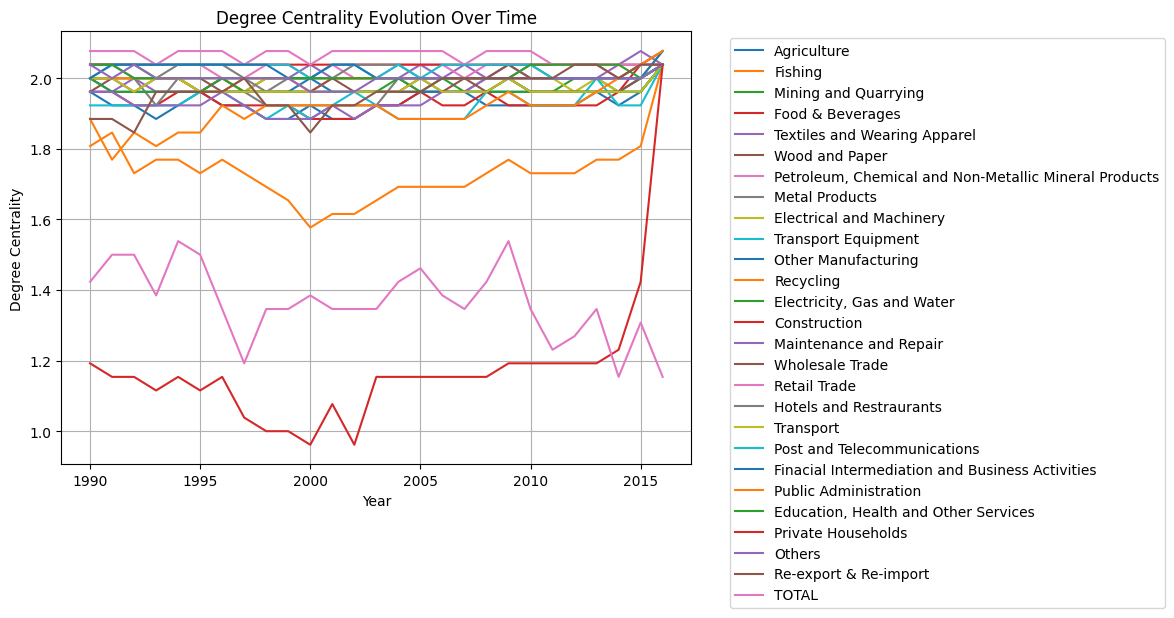

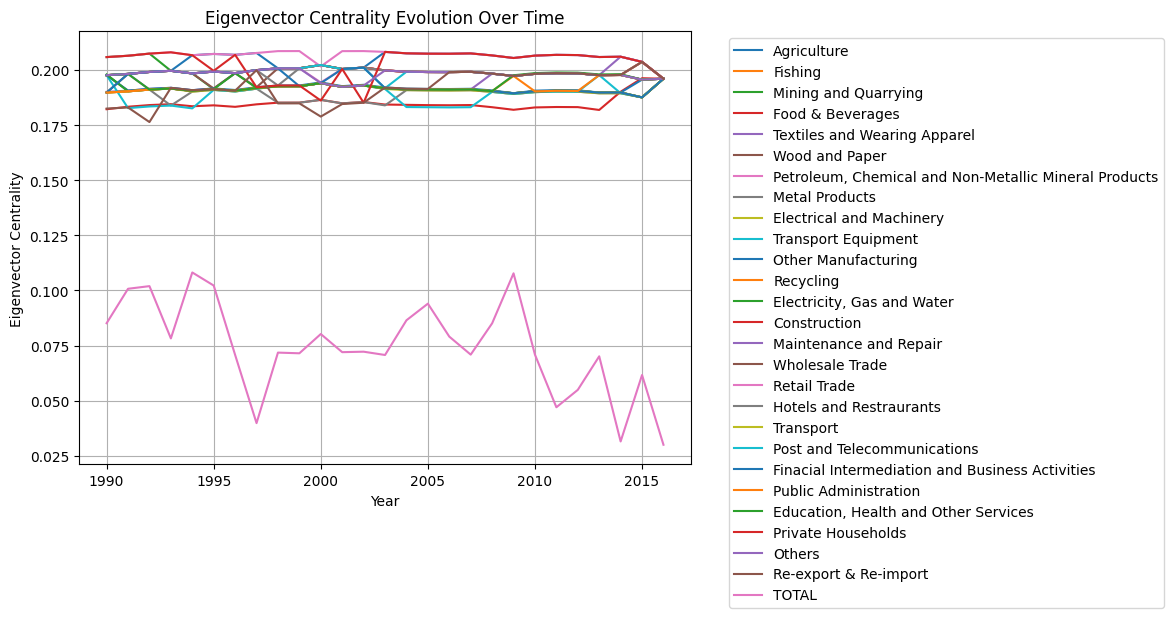

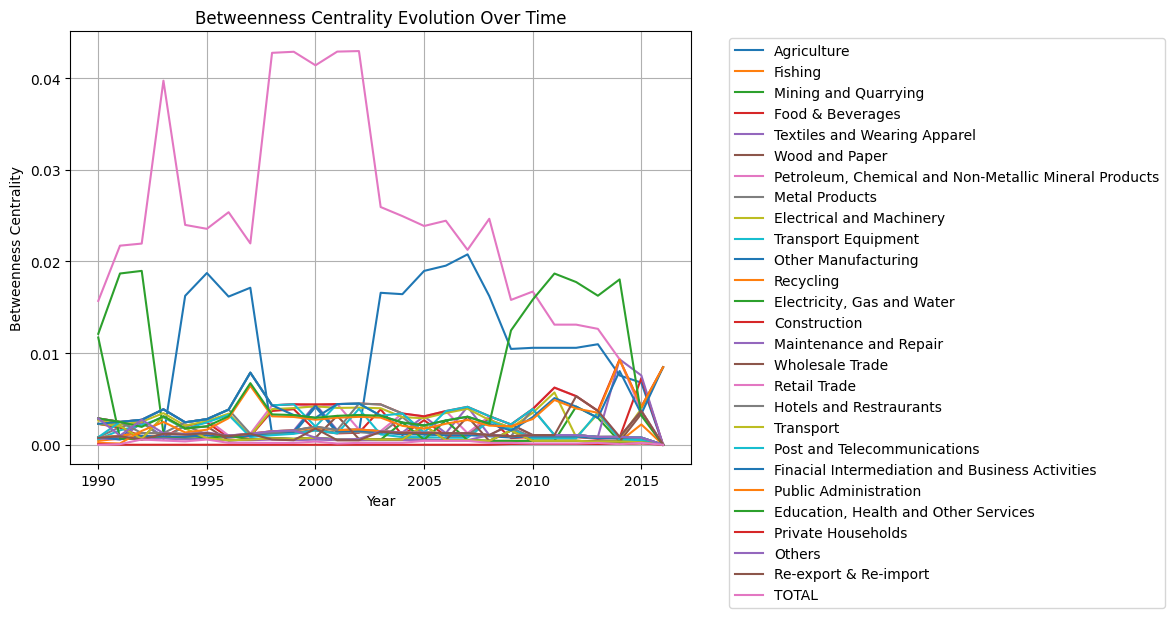

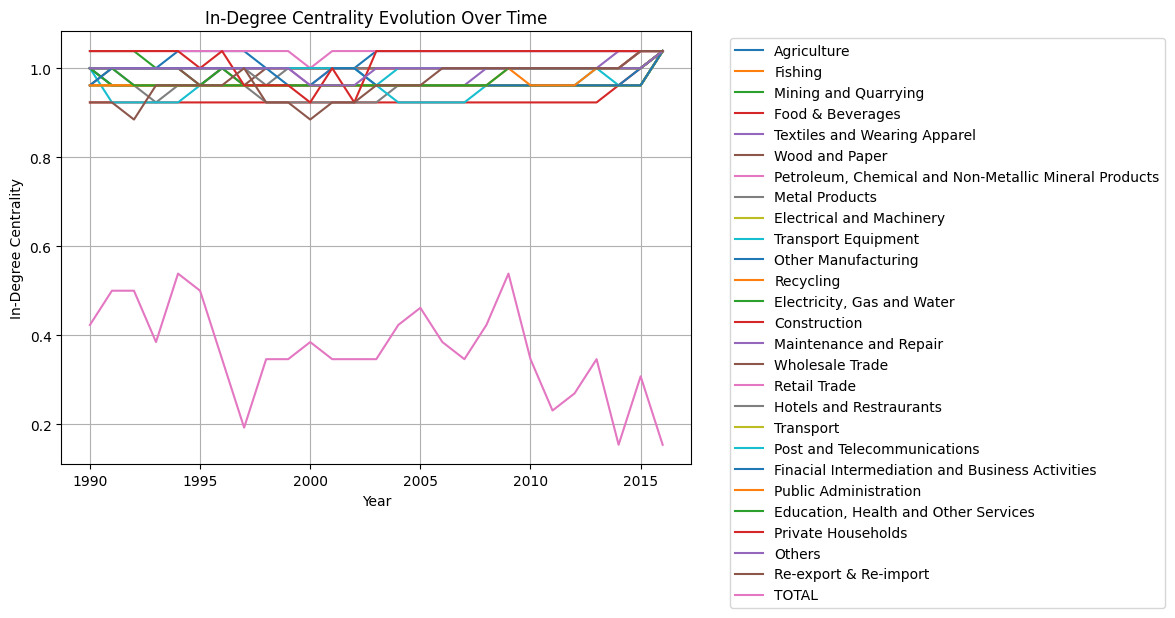

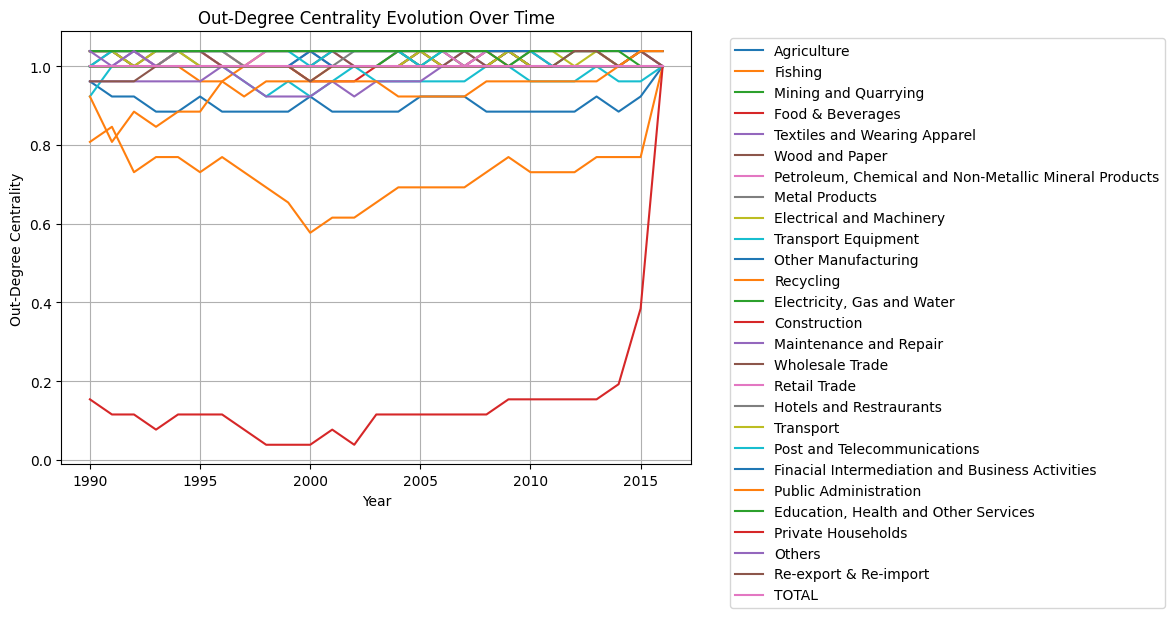

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


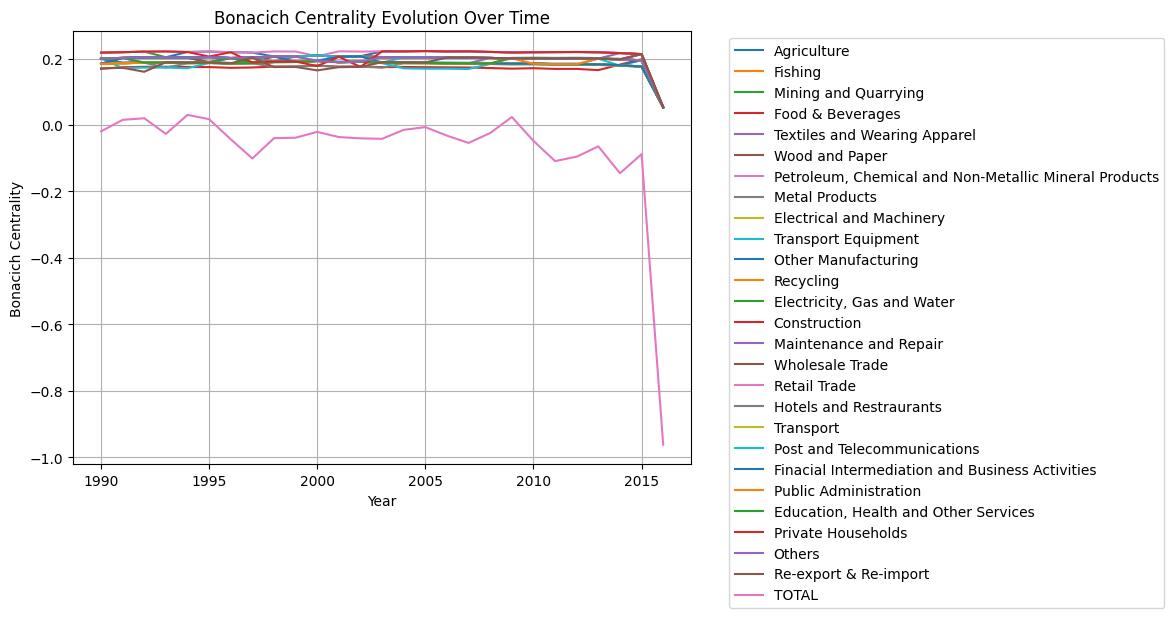

In [ ]:
import numpy as np
import networkx as nx
import pandas as pd
import pickle
from google.colab import drive
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Function to load data for a specific year
def load_year_data(year):
    with open(f'/content/drive/MyDrive/Yannis/variables_for_{year}.pkl', 'rb') as file:
        year_data = pickle.load(file)
    return year_data

# Function to find alpha and beta for Bonacich centrality
def find_alpha_beta(G):
    A = nx.to_numpy_array(G)
    largest_eigenvalue = max(np.linalg.eigvals(A))
    alpha = 0.1 * (1 / largest_eigenvalue)
    beta = 1.0
    return alpha, beta

# Function to compute centrality measures
def compute_centralities(G):
    eigenvector_centrality = nx.eigenvector_centrality_numpy(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    degree_centrality = nx.degree_centrality(G)
    in_degree_centrality = nx.in_degree_centrality(G)
    out_degree_centrality = nx.out_degree_centrality(G)
    alpha, beta = find_alpha_beta(G)
    bonacich_centrality = nx.katz_centrality_numpy(G, alpha=alpha, beta=beta)

    return {
        'eigenvector': eigenvector_centrality,
        'betweenness': betweenness_centrality,
        'degree': degree_centrality,
        'in_degree': in_degree_centrality,
        'out_degree': out_degree_centrality,
        'bonacich': bonacich_centrality
    }

# Function to perform the analysis for a range of years and save results
def perform_analysis_for_years(start_year, end_year):
    all_results = []

    for year in range(start_year, end_year + 1):
        print(f"\nAnalysis for the year {year}:\n")
        year_data = load_year_data(year)

        # Inspect the adjacency matrix
        A = year_data['A']

        # Apply a threshold to the adjacency matrix
        threshold = 0.01  # Example threshold, adjust based on your data
        A_thresholded = np.where(A > threshold, A, 0)

        # Normalize the thresholded adjacency matrix
        A_normalized = A_thresholded / np.max(A_thresholded)

        # Create a directed graph from the normalized adjacency matrix
        G_normalized = nx.DiGraph(A_normalized)

        # Ensure the graph nodes are labeled correctly
        node_labels = year_data['sector_labels']
        mapping = {i: node_labels[i] for i in range(len(node_labels))}
        G_normalized = nx.relabel_nodes(G_normalized, mapping)

        # Compute centrality measures
        centralities = compute_centralities(G_normalized)

        # Prepare DataFrame with results
        year_df = pd.DataFrame({
            'Sector': node_labels,
            'Country': year_data['country_labels'],
            'Year': year,
            'Degree Centrality': [centralities['degree'][sector] for sector in node_labels],
            'Eigenvector Centrality': [centralities['eigenvector'][sector] for sector in node_labels],
            'Betweenness Centrality': [centralities['betweenness'][sector] for sector in node_labels],
            'In-Degree Centrality': [centralities['in_degree'][sector] for sector in node_labels],
            'Out-Degree Centrality': [centralities['out_degree'][sector] for sector in node_labels],
            'Bonacich Centrality': [centralities['bonacich'][sector] for sector in node_labels]
        })

        all_results.append(year_df)
        print(f'Analysis for {year} completed.')

    # Concatenate all yearly results into a single DataFrame
    results_df = pd.concat(all_results, ignore_index=True)

    # Save the results to Google Drive
    results_path = '/content/drive/MyDrive/Yannis/1990-2016_centrality_analysis_results.pkl'
    with open(results_path, 'wb') as file:
        pickle.dump(results_df, file)

    print(f'Results saved to {results_path}')

    return results_df

# Perform the analysis for the years 1990 to 2016
results_df = perform_analysis_for_years(1990, 2016)

# Display the first few rows of the results
print(results_df.head())

# Example plotting function to visualize centrality evolution
def plot_centrality_evolution(df, centrality_type):
    plt.figure(figsize=(12, 6))
    for sector in df['Sector'].unique():
        sector_data = df[df['Sector'] == sector]
        plt.plot(sector_data['Year'], sector_data[centrality_type], label=sector)
    plt.title(f'{centrality_type} Evolution Over Time')
    plt.xlabel('Year')
    plt.ylabel(centrality_type)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot the evolution of each centrality measure
centrality_measures = [
    'Degree Centrality',
    'Eigenvector Centrality',
    'Betweenness Centrality',
    'In-Degree Centrality',
    'Out-Degree Centrality',
    'Bonacich Centrality'
]

for measure in centrality_measures:
    plot_centrality_evolution(results_df, measure)


Waaay better. It is the right calculation. No doubt.



**Deep dive onto these very interesting results**

---

**The Degree Centrality** graph shows that sectors such as Agriculture, Mining and Quarrying, Food & Beverages, Textiles and Wearing Apparel, and Wood and Paper consistently maintain high degree centrality from 1990 to 2016. This indicates that these sectors have a high number of connections with other sectors, reflecting their integral roles in the global economic network. On the other hand, sectors like Fishing, Electricity, Gas and Water, and Public Administration have lower degree centrality, suggesting fewer connections and potentially more specialized or isolated roles within the economy.

**The Eigenvector Centrality** graph reveals that Agriculture, Mining and Quarrying, Food & Beverages, and Textiles and Wearing Apparel not only have many connections but are also highly influential, as they are connected to other well-connected sectors. This suggests that these sectors play pivotal roles in the economic network, influencing a large part of the system through their connections. Conversely, the Fishing sector shows significantly lower eigenvector centrality, indicating it has limited influence and is likely on the periphery of the network.

**Betweenness Centrality**, which measures the extent to which a sector acts as a bridge between other sectors, highlights Fishing as a crucial connector in the early years. This role diminishes over time, with sectors such as Petroleum, Chemical and Non-Metallic Mineral Products, and Textiles and Wearing Apparel emerging as important bridges. This shift suggests a dynamic restructuring of the network over the years, where certain sectors become more central in facilitating interactions between other sectors.

**In-Degree Centrality** focuses on the number of connections directed towards a sector. Agriculture, Mining and Quarrying, and Food & Beverages have high in-degree centrality, indicating they are major recipients of influence or inputs from other sectors. This can be interpreted as these sectors being foundational or essential in the supply chains, receiving a significant amount of raw materials, intermediate goods, or services. In contrast, sectors like Fishing have lower in-degree centrality, indicating they are less influenced by other sectors and may operate more independently.

**Out-Degree Centrality** measures the influence a sector has on others by counting the number of outgoing connections. The same sectors with high in-degree centrality—Agriculture, Mining and Quarrying, and Food & Beverages—also show high out-degree centrality, emphasizing their dual roles as both major influencers and recipients within the network. This indicates their centrality in both upstream and downstream supply chain activities. Fishing and Electricity, Gas and Water sectors, with lower out-degree centrality, are less influential in terms of spreading their outputs to other sectors.

**Bonacich Centrality**, which considers both direct connections and the centrality of neighboring sectors, shows that Agriculture, Mining and Quarrying, Food & Beverages, and Textiles and Wearing Apparel are influential within an influential neighborhood. This reaffirms their critical roles in the network, as their influence is compounded by the influential sectors they are connected to. The consistently lower Bonacich centrality of Fishing further highlights its peripheral role, both in direct influence and within its network neighborhood.

**Implications**

---


The consistent centrality of sectors like Agriculture, Mining and Quarrying, Food & Beverages, and Textiles and Wearing Apparel across different measures indicates their robustness and essential nature in the global economic network. These sectors likely form the backbone of global supply chains, supporting various industries by providing essential inputs and driving economic activities. Their central roles suggest that any disruptions in these sectors could have widespread ripple effects throughout the global economy.

The lower centrality measures for sectors like Fishing and Electricity, Gas and Water suggest more specialized roles. Fishing, with its fluctuating betweenness centrality, indicates periods where it played a more critical bridging role, potentially due to shifts in trade patterns or specific economic policies. The relatively isolated position of these sectors could mean that they are less integrated into the broader network, potentially making them less resilient to global economic changes but also less likely to propagate shocks.

Given the purpose of examining the intersection between network analysis and Structural Path Analysis (SPA), these observations can provide a foundational understanding of how economic sectors are interconnected and how influence and dependencies are distributed across the network. The centrality measures can inform SPA by highlighting which sectors' paths might be most significant in terms of structural impacts and which sectors' interactions could be pivotal in the network's overall behavior.

In summary, the centrality evolution graphs from the Eora26 database underscore the importance of certain key sectors in the global economic network, reveal the dynamic nature of sectoral roles over time, and provide valuable insights for integrating network analysis with Structural Path Analysis. This intersection can enhance our understanding of economic dependencies, influence propagation, and the potential impacts of sector-specific policies or disruptions.

**Discussion**

---

The observation that sectors such as electricity, gas, and water have low centrality measures, despite their apparent importance, can be understood by examining the nature of the data and the network construction. The Eora26 database provides monetary transactions between sectors, reflecting economic flows rather than physical quantities. While electricity, gas, and water are critical for the functioning of the economy, their monetary transactions may not be as large or as numerous as those of other sectors like manufacturing or services. This can lead to lower centrality measures.

Degree centrality, which reflects the number of connections, does not account for the weight or significance of those connections. Electricity, gas, and water sectors might have fewer distinct transactional connections compared to sectors with more diverse economic interactions. Eigenvector centrality measures influence through connections to other influential sectors. If high-value sectors do not depend heavily on direct monetary transactions with electricity, gas, and water, these utility sectors will have lower eigenvector centrality.

Betweenness centrality captures the role of a sector as a bridge in the shortest paths between other sectors. Even though utility sectors are crucial during crises, they might not frequently appear on the shortest economic paths within the dataset's network structure. In-degree and out-degree centrality focus on the number of incoming and outgoing connections. Utility sectors might have fewer but larger transactions, leading to lower scores despite their economic importance. Bonacich centrality reflects both direct and indirect influence. The lower scores for utility sectors suggest limited direct economic influence when considering monetary transactions alone.


**More Paths Computing**

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import zipfile
import pickle

# Function to compute structural path analysis using Taylor expansion
def structural_path_analysis_taylor(A, f, max_order=100, threshold=1e-5):
    paths = []
    I = np.eye(A.shape[0])

    # Calculate direct influence (first-order paths)
    path_values = f
    significant_paths = path_values[path_values > threshold]
    paths.append({'order': 1, 'path_values': significant_paths})  # Order 1 paths

    # Calculate higher-order paths using the Taylor series expansion
    current_power = A  # Start with A^1
    for k in range(2, max_order + 1):
        path_values = np.dot(current_power, f)
        significant_paths = path_values[path_values > threshold]
        paths.append({'order': k, 'path_values': significant_paths})  # Order k paths
        current_power = np.dot(current_power, A)  # Compute A^(k+1) for the next iteration

    return paths

# Define the analysis function
def perform_analysis_for_paths(year):
    # Path to the ZIP file
    zip_file_path = f'/content/drive/MyDrive/Yannis/Eora26_All/Eora26_{year}_bp.zip'

    with zipfile.ZipFile(zip_file_path, 'r') as z:
        # Read specific files into DataFrames
        with z.open(f'Eora26_{year}_bp_T.txt') as file:
            Eora_pp_T = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_FD.txt') as file:
            Eora_pp_FD = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_VA.txt') as file:
            Eora_pp_VA = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_Q.txt') as file:
            Eora_pp_Q = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_QY.txt') as file:
            Eora_pp_QY = pd.read_csv(file, sep='\t', header=None)

        # Also read the label files if needed
        with z.open('labels_T.txt') as file:
            labels_T = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_FD.txt') as file:
            labels_FD = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_VA.txt') as file:
            labels_VA = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_Q.txt') as file:
            labels_Q = pd.read_csv(file, sep='\t', header=None)

    # Filter Emissions Rows
    emission_indices = labels_Q[labels_Q.iloc[:, 0].str.contains(r"\(Gg\)") & ~labels_Q.iloc[:, 0].str.contains("Total")].index

    # Subset the Emissions Data
    Eora_pp_Q_emissions = Eora_pp_Q.iloc[emission_indices]

    # Transform data frames into matrices
    Eora_pp_T_matrix = Eora_pp_T.values
    Eora_pp_Q_emissions_matrix = Eora_pp_Q_emissions.values

    # Calculate total output
    xout = Eora_pp_T_matrix.sum(axis=0) + Eora_pp_FD.sum(axis=0)
    xout = np.where(xout == 0, 1e-10, xout)  # Avoid division by zero

    # Normalize the transaction matrix (T)
    A = Eora_pp_T_matrix / xout

    # Normalize the externalities (Q)
    f_matrix = Eora_pp_Q_emissions_matrix / xout

    # Sum across emissions to create a 1-dimensional vector
    f = f_matrix.sum(axis=0)

    # Perform structural path analysis using Taylor series method with increased paths
    paths_taylor = structural_path_analysis_taylor(A, f, max_order=50, threshold=1e-5)

    # Flatten paths into a DataFrame for easier analysis
    all_paths_taylor = []
    for path in paths_taylor:
        k = path['order']
        path_values = path['path_values']
        for i, value in enumerate(path_values):
            all_paths_taylor.append({'Order': k, 'Path_Index': i, 'Impact': value})

    paths_df_taylor = pd.DataFrame(all_paths_taylor)

    # Save the paths data to a CSV file
    paths_df_taylor.to_csv(f'/content/drive/MyDrive/Yannis/100_paths_analysis_{year}.csv', index=False)

    return paths_df_taylor

# Example usage:
years = range(1990, 2016)
for year in years:
    print(f"\nComputing paths for the year {year}:\n")
    paths_df = perform_analysis_for_paths(year)
    print(f'Paths for {year} saved in the drive')


**Structural Path Analysis deep-dive**

---


Let's compare paths

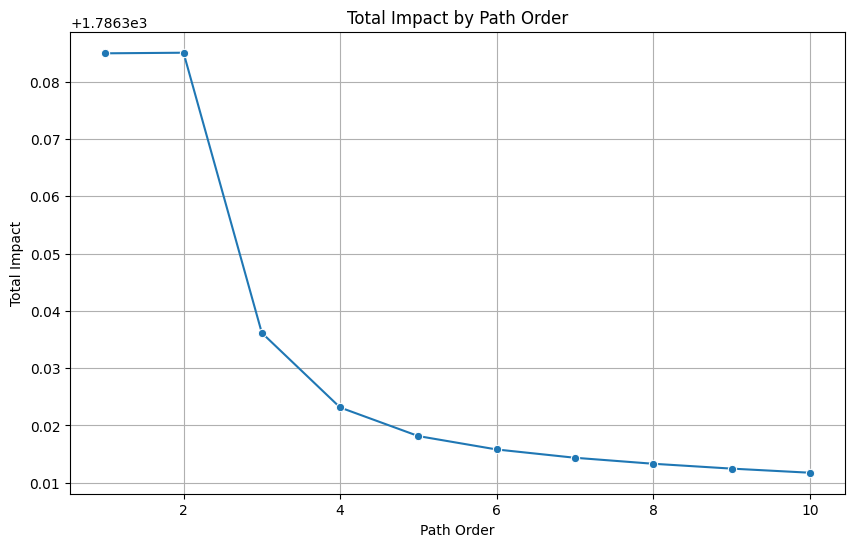

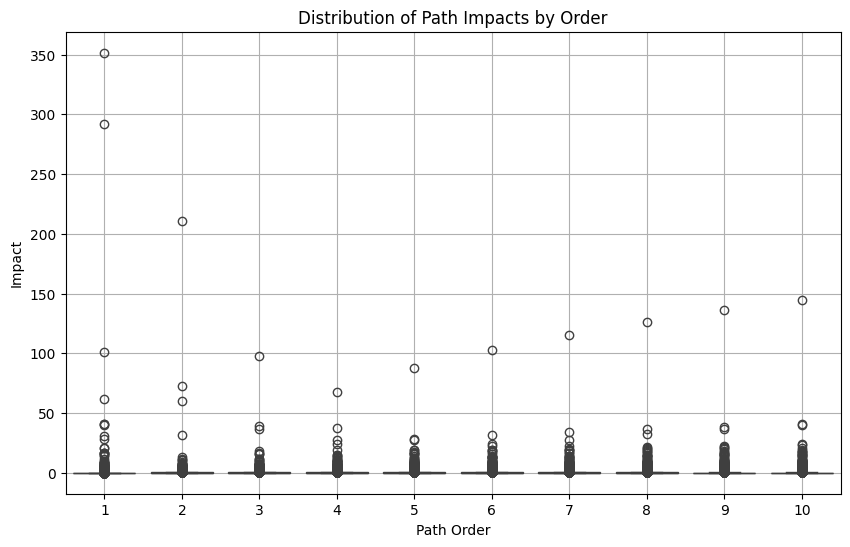

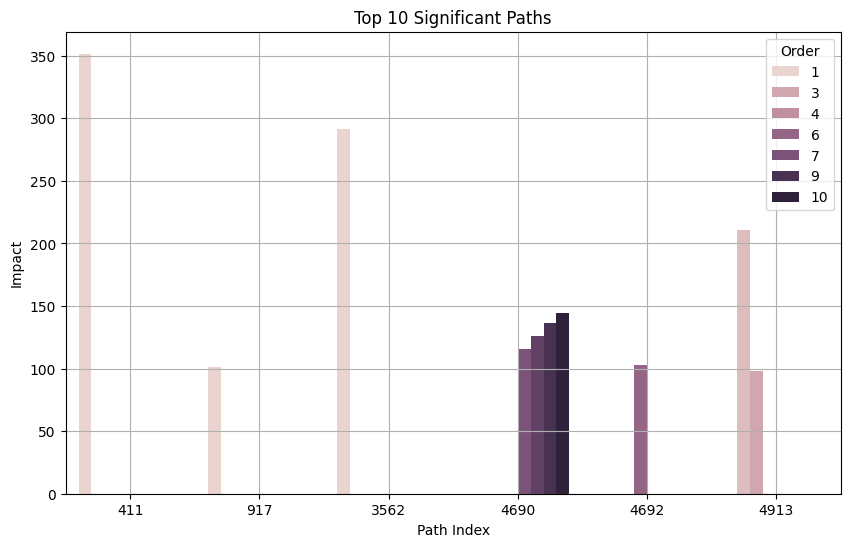

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

paths_df_taylor = pd.DataFrame()

for year in range(1990, 2016):
    print(f"\nLoading for the year {year}:\n")
    pdy = pd.read_csv(f'/content/drive/MyDrive/Yannis/100_paths_analysis_{year}.csv')
    paths_df_taylor = pd.concat([paths_df_taylor, pdy])

# Plot total impact by path order
def plot_total_impact_by_order(paths_df_taylor):
    impact_by_order = paths_df_taylor.groupby('Order')['Impact'].sum().reset_index()
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Order', y='Impact', data=impact_by_order, marker='o')
    plt.title('Total Impact by Path Order')
    plt.xlabel('Path Order')
    plt.ylabel('Total Impact')
    plt.grid(True)
    plt.show()

# Plot the distribution of impacts by path order using a boxplot to see the spread
def plot_distribution_of_impacts(paths_df_taylor):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Order', y='Impact', data=paths_df_taylor)
    plt.title('Distribution of Path Impacts by Order')
    plt.xlabel('Path Order')
    plt.ylabel('Impact')
    plt.grid(True)
    plt.show()

# Plot the top N significant paths
def plot_top_n_significant_paths(paths_df_taylor, top_n=100):
    top_n_paths = paths_df_taylor.nlargest(top_n, 'Impact')
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Path_Index', y='Impact', hue='Order', data=top_n_paths)
    plt.title(f'Top {top_n} Significant Paths')
    plt.xlabel('Path Index')
    plt.ylabel('Impact')
    plt.grid(True)
    plt.show()

# Example usage
plot_total_impact_by_order(paths_df_taylor)
plot_distribution_of_impacts(paths_df_taylor)
plot_top_n_significant_paths(paths_df_taylor, top_n=100)



**Interpretation of the Graphs**

---


1. Total Impact by Path Order

Description: This line plot shows the total impact aggregated by path order.

Observation:
The total impact decreases significantly as the path order increases.
The highest total impact is at order 1, indicating that direct influences have the most substantial impact.
The impact reduces sharply from order 2 onwards and continues to decline gradually for higher orders.

2. Distribution of Path Impacts by Order

Description: This box plot displays the distribution of impacts for each path order.

Observation:
There is a high variance in impacts, especially for the lower path orders.
The box plot for each order shows many outliers, indicating that while most paths have relatively low impacts, some paths have very high impacts.
The median impact (central line in each box) is relatively low across all orders, but the range of impacts (height of the boxes and whiskers) is wider for lower orders.

3. Top 10 Significant Paths

Description: This bar plot highlights the top 10 significant paths based on their impact.

Observation:
The most impactful paths are spread across different orders, indicating that significant paths can occur at various levels of indirect influence.
The highest impact path belongs to path index 411 at order 1.
Other significant paths are found at higher orders (e.g., orders 3, 4, 6, 7, 9, and 10), suggesting that while higher-order paths generally have lower total impacts, individual high-impact paths exist.
The color intensity in the bar plot corresponds to the path order, with darker shades indicating higher orders.

---



# Selected Countries SPA & Centrality Analysis

---




**ONLY IF NECESSARY FOR SOMETHING ELSE - Load and name Dataframes**

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import pandas as pd

def extract_Eora26_data(year, previous_year):
    # Path to the ZIP file
    zip_file_path = f'/content/drive/MyDrive/Yannis/Eora26_All/Eora26_{year}_bp.zip'
    zip_file_path_prev = f'/content/drive/MyDrive/Yannis/Eora26_All/Eora26_{previous_year}_bp.zip'

    with zipfile.ZipFile(zip_file_path, 'r') as z, zipfile.ZipFile(zip_file_path_prev, 'r') as z_prev:
        # Read specific files into DataFrames for the current year
        with z.open(f'Eora26_{year}_bp_T.txt') as file:
            Eora_pp_T = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_FD.txt') as file:
            Eora_pp_FD = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_VA.txt') as file:
            Eora_pp_VA = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_Q.txt') as file:
            Eora_pp_Q = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_QY.txt') as file:
            Eora_pp_QY = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_T.txt') as file:
            labels_T = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_FD.txt') as file:
            labels_FD = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_VA.txt') as file:
            labels_VA = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_Q.txt') as file:
            labels_Q = pd.read_csv(file, sep='\t', header=None)

        # Read specific files into DataFrames for the previous year
        with z_prev.open(f'Eora26_{previous_year}_bp_T.txt') as file:
            Eora_pp_T_prev = pd.read_csv(file, sep='\t', header=None)

        with z_prev.open(f'Eora26_{previous_year}_bp_FD.txt') as file:
            Eora_pp_FD_prev = pd.read_csv(file, sep='\t', header=None)

        with z_prev.open(f'Eora26_{previous_year}_bp_VA.txt') as file:
            Eora_pp_VA_prev = pd.read_csv(file, sep='\t', header=None)

        with z_prev.open(f'Eora26_{previous_year}_bp_Q.txt') as file:
            Eora_pp_Q_prev = pd.read_csv(file, sep='\t', header=None)

        with z_prev.open(f'Eora26_{previous_year}_bp_QY.txt') as file:
            Eora_pp_QY_prev = pd.read_csv(file, sep='\t', header=None)

        with z_prev.open('labels_T.txt') as file:
            labels_T_prev = pd.read_csv(file, sep='\t', header=None)

        with z_prev.open('labels_FD.txt') as file:
            labels_FD_prev = pd.read_csv(file, sep='\t', header=None)

        with z_prev.open('labels_VA.txt') as file:
            labels_VA_prev = pd.read_csv(file, sep='\t', header=None)

        with z_prev.open('labels_Q.txt') as file:
            labels_Q_prev = pd.read_csv(file, sep='\t', header=None)

    return (Eora_pp_T, Eora_pp_FD, Eora_pp_VA, Eora_pp_Q, Eora_pp_QY, labels_T, labels_FD, labels_VA, labels_Q,
            Eora_pp_T_prev, Eora_pp_FD_prev, Eora_pp_VA_prev, Eora_pp_Q_prev, Eora_pp_QY_prev, labels_T_prev, labels_FD_prev, labels_VA_prev, labels_Q_prev)

# Call the function
(Eora_pp_T, Eora_pp_FD, Eora_pp_VA, Eora_pp_Q, Eora_pp_QY, labels_T, labels_FD, labels_VA, labels_Q,
 Eora_pp_T_prev, Eora_pp_FD_prev, Eora_pp_VA_prev, Eora_pp_Q_prev, Eora_pp_QY_prev, labels_T_prev, labels_FD_prev, labels_VA_prev, labels_Q_prev) = extract_Eora26_data(2010, 2009)

 # Step 1: Insert the new column as the first column and name it 'Sector' for T
Eora_pp_T.columns = labels_T.iloc[:, 0]
Eora_pp_T.insert(0, 'Sector', labels_T.iloc[:, 3].values)

# Step 2: Create a new row named 'Sector' with the data from labels_T.iloc[:, 3]
new_row_T = pd.DataFrame([['Sector'] + labels_T.iloc[:, 3].values.tolist()], columns=Eora_pp_T.columns)

# Step 3: Prepend the new row to Eora_pp_T
Eora_pp_T = pd.concat([new_row_T, Eora_pp_T], axis=0, ignore_index=True)

# Step 4: Set the index to the original labels with the name 'Country'
Eora_pp_T.index = ['Country'] + labels_T.iloc[:, 1].tolist()
Eora_pp_T.index.name = 'Country'

# Step 5: Insert the new column as the first column and name it 'Sector' for FD
Eora_pp_FD.columns = labels_FD.iloc[:, 0]

# Ensure the length of the labels matches the number of rows in Eora_pp_FD
if len(labels_T.iloc[:, 3].values) == len(Eora_pp_FD):
    Eora_pp_FD.insert(0, 'Sector', labels_T.iloc[:, 3].values)
else:
    print("Mismatch in the number of rows between labels_T and Eora_pp_FD")

# Step 6: Create a new row named 'Consumer' with the data from labels_FD.iloc[:, 3]
if len(labels_FD.iloc[:, 3].values) == len(Eora_pp_FD.columns) - 1:  # Adjust for the new 'Sector' column
    new_row_FD = pd.DataFrame([['Consumer'] + labels_FD.iloc[:, 3].values.tolist()], columns=Eora_pp_FD.columns)
else:
    print("Mismatch in the number of columns in Eora_pp_FD when adding the new row.")

# Step 7: Prepend the new row to Eora_pp_FD
Eora_pp_FD = pd.concat([new_row_FD, Eora_pp_FD], axis=0, ignore_index=False)

# Step 8: Set the index to the original labels with the name 'Country'
Eora_pp_FD.index = ['Country'] + labels_T.iloc[:, 1].tolist()
Eora_pp_FD.index.name = 'Country'

# Step 13: Insert the new column as the first column and name it 'Sector' for VA
Eora_pp_VA.columns = labels_T.iloc[:, 0]
Eora_pp_VA.insert(0, 'Primary Input', labels_VA.iloc[:, 1].values[:len(Eora_pp_VA)])  # Adjust length to match rows

# Step 14: Create a new row named 'Sector' with the data from labels_VA.iloc[:, 2]
new_row_VA = pd.DataFrame([['Sector'] + labels_T.iloc[:, 3].values.tolist()], columns=Eora_pp_VA.columns)

# Step 15: Prepend the new row to Eora_pp_VA
Eora_pp_VA = pd.concat([new_row_VA, Eora_pp_VA], axis=0, ignore_index=True)

# Step 16: Set the index to the original labels with the name 'Country'
Eora_pp_VA.index = ['Data type'] + labels_VA.iloc[:, 0].tolist()
Eora_pp_VA.index.name = 'Country'

# Step 1: Set the column names using labels_T.iloc[:, 0] for Q
Eora_pp_Q.columns = labels_T.iloc[:, 0]

# Step 2: Insert the new column as the first column and name it 'Sector'
Eora_pp_Q.insert(0, 'Sector', labels_Q.iloc[:, 1].values)

# Step 3: Create a new row named 'Sector' with the data from labels_T.iloc[:, 3]
# This will be used to match the column names (4915 columns)
new_row_Q = pd.DataFrame([['Sector'] + labels_T.iloc[:, 3].values.tolist()], columns=Eora_pp_Q.columns)

# Step 4: Prepend the new row to Eora_pp_Q
Eora_pp_Q = pd.concat([new_row_Q, Eora_pp_Q], axis=0, ignore_index=True)

# Step 5: Set the index to the original labels from labels_Q.iloc[:, 0] with the name 'Country'
Eora_pp_Q.index = ['Data type'] + labels_Q.iloc[:, 0].tolist()
Eora_pp_Q.index.name = 'Country'

Eora_pp_QY.columns = labels_FD.iloc[:,0]
Eora_pp_QY.insert(0, 'Sector', labels_Q.iloc[:, 1].values)
new_row_QY = pd.DataFrame([['Consumer'] + labels_FD.iloc[:, 3].values.tolist()], columns=Eora_pp_FD.columns)
Eora_pp_QY = pd.concat([new_row_QY, Eora_pp_QY], axis=0, ignore_index=True)
Eora_pp_QY.index = ['Data type'] + labels_Q.iloc[:, 0].tolist()
Eora_pp_QY.index.name = 'Country'

**Compute and save the paths from Korea, Brazil and Bangladesh**

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import zipfile
import pickle

def generate_unique_geometric_sequence(max_num, base=1.15):
    sequence = []
    i = 1

    while i <= max_num:
        sequence.append(int(round(i)))
        i *= base  # Multiply by base to increase the step size progressively

    # Ensure the sequence includes the max_num if it wasn't included
    if sequence[-1] != max_num:
        sequence.append(max_num)

    # Remove duplicates and return unique sequence
    unique_sequence = np.unique(sequence).tolist()

    return unique_sequence

def structural_path_analysis_taylor(A, f, max_order=15, threshold=1e-5, base=1.15):
    paths = []
    I = np.eye(A.shape[0])

    # Generate the unique geometric sequence
    sequence = generate_unique_geometric_sequence(max_order, base)

    # Calculate direct influence (first-order paths)
    current_power = I
    path_values = np.dot(current_power, f)
    significant_paths = path_values[path_values > threshold]
    paths.append({'order': 1, 'path_values': significant_paths})  # Order 1 paths

    # Calculate higher-order paths based on the unique sequence
    current_power = A  # Start with A^1

    for k in sequence[1:]:  # Skip the first element as it's already computed
        current_power = np.linalg.matrix_power(A, k)
        path_values = np.dot(current_power, f)
        significant_paths = path_values[path_values > threshold]
        paths.append({'order': k, 'path_values': significant_paths})

    return paths

def perform_analysis(year):
    print(f'Perform analysis for year: {year}\n')
    # Path to the ZIP file
    zip_file_path = f'/content/drive/MyDrive/Yannis/Eora26_All/Eora26_{year}_bp.zip'

    with zipfile.ZipFile(zip_file_path, 'r') as z:
        # Read specific files into DataFrames
        with z.open(f'Eora26_{year}_bp_T.txt') as file:
            Eora_pp_T = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_FD.txt') as file:
            Eora_pp_FD = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_VA.txt') as file:
            Eora_pp_VA = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_Q.txt') as file:
            Eora_pp_Q = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_QY.txt') as file:
            Eora_pp_QY = pd.read_csv(file, sep='\t', header=None)

        # Also read the label files if needed
        with z.open('labels_T.txt') as file:
            labels_T = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_FD.txt') as file:
            labels_FD = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_VA.txt') as file:
            labels_VA = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_Q.txt') as file:
            labels_Q = pd.read_csv(file, sep='\t', header=None)

    # Filter Emissions Rows
    emission_indices = labels_Q[labels_Q.iloc[:, 0].str.contains(r"\(Gg\)") & ~labels_Q.iloc[:, 0].str.contains("Total")].index

    # Subset the Emissions Data
    Eora_pp_Q_emissions = Eora_pp_Q.iloc[emission_indices]

    # Transform data frames into matrices
    Eora_pp_T_matrix = Eora_pp_T.values
    Eora_pp_Q_emissions_matrix = Eora_pp_Q_emissions.values

    # Calculate total output
    FD_vector = Eora_pp_FD.sum(axis=1)  # Sum across all final demand categories for each sector
    xout = Eora_pp_T_matrix.sum(axis=0) + FD_vector
    xout = np.where(xout == 0, 1e-10, xout)  # Avoid division by zero

    # Normalize the transaction matrix (T)
    A = Eora_pp_T_matrix / xout

    # Normalize the externalities (Q)
    f_matrix = Eora_pp_Q_emissions_matrix / xout

    # Sum across emissions to create a 1-dimensional vector
    f = f_matrix.sum(axis=0)

    # Extract sector labels based on the actual number of sectors
    num_sectors = len(f)
    sector_labels = labels_T.iloc[:num_sectors, 3].values
    country_labels = labels_T.iloc[:num_sectors, 1].values

    # Create combined country-sector labels
    country_sector_labels = [f"{country}_{sector}" for country, sector in zip(country_labels, sector_labels)]

    # Perform structural path analysis using Taylor series method
    print('Perform structural path analysis using Taylor series method\n')
    paths_taylor = structural_path_analysis_taylor(A, f, max_order=5, threshold=1e-5)

    # Flatten paths into a DataFrame for easier analysis
    all_paths_taylor = []
    threshold = 1e-5
    for path in paths_taylor:
        k = path['order']
        path_values = path['path_values']
        for i, value in enumerate(path_values):
            if value > threshold:
                country_sector = country_sector_labels[i]
                country, sector = country_sector.split('_')
                all_paths_taylor.append({'Order': k, 'Country': country, 'Sector': sector, 'Impact': value})

    selected_countries = ('BGD', 'KOR', 'BRA')
    paths_df_taylor = pd.DataFrame(all_paths_taylor)

    print('Paths successfully computed\n')

    # Filter by selected countries
    paths_taylor = structural_path_analysis_taylor(A, f, max_order=4915, threshold=1e-5, base=1.5)

    df = pd.DataFrame({
        'Order': paths_df_taylor_selected['Order'],
        'Country': paths_df_taylor_selected['Country'],
        'Sector': paths_df_taylor_selected['Sector'],
        'Impact': paths_df_taylor_selected['Impact'],
        'Year': year
    })

    # Save all relevant variables for this year, including the databases
    save_path = f'/content/drive/MyDrive/Yannis/variables_for_{year}_selected_countries.pkl'
    with open(save_path, 'wb') as file:
        pickle.dump({
            'f': f,
            'A': A,
            'paths_taylor': paths_taylor,
            'paths_df_taylor_selected': paths_df_taylor_selected,
            'sector_labels': sector_labels,
            'country_labels': country_labels,
            'country_sector_labels': country_sector_labels,
        }, file)

    print(f"Variables for year {year} saved to {save_path}\n")

    return df, paths_df_taylor_selected

# Example usage
year = 1990
df, paths_df_taylor_selected = perform_analysis(year)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Perform analysis for year: 1990

Perform structural path analysis using Taylor series method

Paths successfully computed

Variables for year 1990 saved to /content/drive/MyDrive/Yannis/variables_for_1990_selected_countries.pkl



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import zipfile
import pickle

# Use a more efficient matrix calculation method : the exponention by squaring method
def matrix_power(A, k):
    result = np.eye(A.shape[0])  # Start with the identity matrix
    base = A

    while k > 0:
        if k % 2 == 1:  # If k is odd, multiply the result by the base
            result = np.dot(result, base)
            print('Calculation ongoing ...')
        base = np.dot(base, base)  # Square the base
        k //= 2  # Divide k by 2

    return result

def generate_unique_geometric_sequence(max_num, base=1.15):
    sequence = []
    i = 1

    while i <= max_num:
        sequence.append(int(round(i)))
        i *= base  # Multiply by base to increase the step size progressively

    # Ensure the sequence includes the max_num if it wasn't included
    if sequence[-1] != max_num:
        sequence.append(max_num)

    # Remove duplicates and return unique sequence
    unique_sequence = np.unique(sequence).tolist()
    print('Exponential sequence generated')

    return unique_sequence

def structural_path_analysis_taylor(A, f, max_order=100, threshold=1e-5, base=1.15):
    paths = []
    I = np.eye(A.shape[0])

    # Generate the unique geometric sequence for higher-order path analysis
    sequence = generate_unique_geometric_sequence(max_order, base)

    # Calculate direct influence (first-order paths)
    current_power = I
    path_values = np.dot(current_power, f)
    significant_paths = path_values[path_values > threshold]
    paths.append({'order': 1, 'path_values': significant_paths})  # Order 1 paths

    # Calculate and store the impact of each order separately using the efficient matrix_power function
    for k in sequence[1:]:  # Skip the first element as it's already computed
        current_power = matrix_power(A, k)  # Efficiently compute A^k using exponentiation by squaring
        path_values = np.dot(current_power, f)
        print(f'Order {k} computed')

        # Filter for significant paths
        significant_paths = path_values[path_values > threshold]
        print(f'Significant paths for order {k} found')

        # Store the path values for this specific order
        paths.append({'order': k, 'path_values': significant_paths})
        print(f'Path values for order {k} stored')

    return paths


def perform_analysis(year):
    print(f'Perform analysis for year: {year}\n')
    # Path to the ZIP file
    print('Load Data ...')
    zip_file_path = f'/content/drive/MyDrive/Yannis/Eora26_All/Eora26_{year}_bp.zip'

    with zipfile.ZipFile(zip_file_path, 'r') as z:
        # Read specific files into DataFrames
        with z.open(f'Eora26_{year}_bp_T.txt') as file:
            Eora_pp_T = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_FD.txt') as file:
            Eora_pp_FD = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_VA.txt') as file:
            Eora_pp_VA = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_Q.txt') as file:
            Eora_pp_Q = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_QY.txt') as file:
            Eora_pp_QY = pd.read_csv(file, sep='\t', header=None)

        # Also read the label files if needed
        with z.open('labels_T.txt') as file:
            labels_T = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_FD.txt') as file:
            labels_FD = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_VA.txt') as file:
            labels_VA = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_Q.txt') as file:
            labels_Q = pd.read_csv(file, sep='\t', header=None)

    # Filter Emissions Rows
    print('Filter Data ...\n')
    emission_indices = labels_Q[labels_Q.iloc[:, 0].str.contains(r"\(Gg\)") & ~labels_Q.iloc[:, 0].str.contains("Total")].index

    # Subset the Emissions Data
    Eora_pp_Q_emissions = Eora_pp_Q.iloc[emission_indices]

    # Transform data frames into matrices
    Eora_pp_T_matrix = Eora_pp_T.values
    Eora_pp_Q_emissions_matrix = Eora_pp_Q_emissions.values

    # Calculate total output
    print('Calculate total output\n')
    FD_vector = Eora_pp_FD.sum(axis=1)  # Sum across all final demand categories for each sector
    xout = Eora_pp_T_matrix.sum(axis=0) + FD_vector
    xout = np.where(xout == 0, 1e-10, xout)  # Avoid division by zero

    # Normalize the transaction matrix (T)
    A = Eora_pp_T_matrix / xout

    # Normalize the externalities (Q)
    f_matrix = Eora_pp_Q_emissions_matrix / xout

    # Sum across emissions to create a 1-dimensional vector
    f = f_matrix.sum(axis=0)

    # Extract sector labels based on the actual number of sectors
    num_sectors = len(f)
    sector_labels = labels_T.iloc[:num_sectors, 3].values
    country_labels = labels_T.iloc[:num_sectors, 1].values

    # Create combined country-sector labels
    country_sector_labels = [f"{country}_{sector}" for country, sector in zip(country_labels, sector_labels)]

    # Perform structural path analysis using Taylor series method
    print('Perform structural path analysis using Taylor series method\n')
    paths_taylor = structural_path_analysis_taylor(A, f, max_order=100, threshold=1e-5, base=1.5)

    # Flatten paths into a DataFrame for easier analysis
    all_paths_taylor = []
    threshold = 1e-5
    for path in paths_taylor:
        k = path['order']
        path_values = path['path_values']
        for i, value in enumerate(path_values):
            if value > threshold:
                country_sector = country_sector_labels[i]
                country, sector = country_sector.split('_')
                all_paths_taylor.append({'Order': k, 'Country': country, 'Sector': sector, 'Impact': value})

    selected_countries = ('BGD', 'KOR', 'BRA')
    paths_df_taylor = pd.DataFrame(all_paths_taylor)
    paths_df_taylor_selected = paths_df_taylor[paths_df_taylor['Country'].isin(selected_countries)]

    print('Paths successfully computed\n')

    # Filter by selected countries
    print('Filter by selected countries\n')

    df = pd.DataFrame({
        'Order': paths_df_taylor_selected['Order'],
        'Country': paths_df_taylor_selected['Country'],
        'Sector': paths_df_taylor_selected['Sector'],
        'Impact': paths_df_taylor_selected['Impact'],
        'Year': year
    })

    # Save all relevant variables for this year, including the databases
    save_path = f'/content/drive/MyDrive/Yannis/variables_for_{year}_selected_countries.pkl'
    with open(save_path, 'wb') as file:
        pickle.dump({
            'f': f,
            'A': A,
            'paths_taylor': paths_taylor,
            'paths_df_taylor_selected': paths_df_taylor_selected,
            'sector_labels': sector_labels,
            'country_labels': country_labels,
            'country_sector_labels': country_sector_labels,
        }, file)

    print(f"Variables for year {year} saved to {save_path}\n")

    return df, paths_df_taylor_selected

# Example usage
year = 1990
df, paths_df_taylor_selected = perform_analysis(year)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Perform analysis for year: 1990

Load Data ...
Filter Data ...

Calculate total output

Perform structural path analysis using Taylor series method

Exponential sequence generated
Calculation ongoing ...
Order 2 computed
Significant paths for order 2 found
Path values for order 2 stored
Calculation ongoing ...
Calculation ongoing ...
Order 3 computed
Significant paths for order 3 found
Path values for order 3 stored
Calculation ongoing ...
Calculation ongoing ...
Order 5 computed
Significant paths for order 5 found
Path values for order 5 stored
Calculation ongoing ...
Order 8 computed
Significant paths for order 8 found
Path values for order 8 stored
Calculation ongoing ...
Calculation ongoing ...
Calculation ongoing ...
Order 11 computed
Significant paths for order 11 found
Path values for order 11 stored
Calculation ongoing ...
Calculation ongoing ...
Orde

In [ ]:
!pip uninstall -y cupy-cuda11x cupy-cuda12x cupy
!conda uninstall cupy
!pip install cupy-cuda11x

Found existing installation: cupy-cuda11x 13.2.0
Uninstalling cupy-cuda11x-13.2.0:
  Successfully uninstalled cupy-cuda11x-13.2.0
Found existing installation: cupy-cuda12x 12.2.0
Uninstalling cupy-cuda12x-12.2.0:
  Successfully uninstalled cupy-cuda12x-12.2.0
/bin/bash: line 1: conda: command not found
  Using cached cupy_cuda11x-13.2.0-cp310-cp310-manylinux2014_x86_64.whl.metadata (2.7 kB)
Using cached cupy_cuda11x-13.2.0-cp310-cp310-manylinux2014_x86_64.whl (95.4 MB)


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
!nvcc --version
!pip install cupy-cuda12x

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.5/89.5 MB 8.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import zipfile
import pickle

# Sequential matrix multiplication method (without exponentiation)
def sequential_matrix_multiplication(A, k):
    result = np.eye(A.shape[0])  # Start with the identity matrix
    for _ in range(k):
        result = np.dot(result, A)  # Multiply by A sequentially
        print('Calculation ongoing ...')
    return result

def generate_unique_geometric_sequence(max_num, base=1.15):
    sequence = []
    i = 1

    while i <= max_num:
        sequence.append(int(round(i)))
        i *= base  # Multiply by base to increase the step size progressively

    # Ensure the sequence includes the max_num if it wasn't included
    if sequence[-1] != max_num:
        sequence.append(max_num)

    # Remove duplicates and return unique sequence
    unique_sequence = np.unique(sequence).tolist()
    print('Exponential sequence generated')

    return unique_sequence

def structural_path_analysis_taylor(A, f, max_order=30, threshold=1e-5, base=1.15):
    paths = []
    I = np.eye(A.shape[0])

    # Generate the unique geometric sequence for higher-order path analysis
    sequence = generate_unique_geometric_sequence(max_order, base)

    # Calculate direct influence (first-order paths)
    current_power = I
    path_values = np.dot(current_power, f)
    significant_paths = path_values[path_values > threshold]
    paths.append({'order': 1, 'path_values': significant_paths})  # Order 1 paths

    # Calculate and store the impact of each order separately using the sequential matrix multiplication
    for k in sequence[1:]:  # Skip the first element as it's already computed
        current_power = sequential_matrix_multiplication(A, k)  # Sequentially compute A^k
        path_values = np.dot(current_power, f)
        print(f'Order {k} computed')

        # Filter for significant paths
        significant_paths = path_values[path_values > threshold]
        print(f'Significant paths for order {k} found')

        # Store the path values for this specific order
        paths.append({'order': k, 'path_values': path_values})
        print(f'Path values for order {k} stored')

    return paths

def perform_analysis(year):
    print(f'Perform analysis for year: {year}\n')
    # Path to the ZIP file
    print('Load Data ...')
    zip_file_path = f'/content/drive/MyDrive/Yannis/Eora26_All/Eora26_{year}_bp.zip'

    with zipfile.ZipFile(zip_file_path, 'r') as z:
        # Read specific files into DataFrames
        with z.open(f'Eora26_{year}_bp_T.txt') as file:
            Eora_pp_T = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_FD.txt') as file:
            Eora_pp_FD = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_VA.txt') as file:
            Eora_pp_VA = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_Q.txt') as file:
            Eora_pp_Q = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_QY.txt') as file:
            Eora_pp_QY = pd.read_csv(file, sep='\t', header=None)

        # Also read the label files if needed
        with z.open('labels_T.txt') as file:
            labels_T = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_FD.txt') as file:
            labels_FD = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_VA.txt') as file:
            labels_VA = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_Q.txt') as file:
            labels_Q = pd.read_csv(file, sep='\t', header=None)

    # Filter Emissions Rows
    print('Filter Data ...\n')
    emission_indices = labels_Q[labels_Q.iloc[:, 0].str.contains(r"\(Gg\)") & ~labels_Q.iloc[:, 0].str.contains("Total")].index

    # Subset the Emissions Data
    Eora_pp_Q_emissions = Eora_pp_Q.iloc[emission_indices]

    # Transform data frames into matrices
    Eora_pp_T_matrix = Eora_pp_T.values
    Eora_pp_Q_emissions_matrix = Eora_pp_Q_emissions.values

    # Calculate total output
    print('Calculate total output\n')
    FD_vector = Eora_pp_FD.sum(axis=1)  # Sum across all final demand categories for each sector
    xout = Eora_pp_T_matrix.sum(axis=0) + FD_vector
    xout = np.where(xout == 0, 1e-10, xout)  # Avoid division by zero

    # Normalize the transaction matrix (T)
    A = Eora_pp_T_matrix / xout

    # Normalize the externalities (Q)
    f_matrix = Eora_pp_Q_emissions_matrix / xout

    # Sum across emissions to create a 1-dimensional vector
    f = f_matrix.sum(axis=0)

    # Extract sector labels based on the actual number of sectors
    num_sectors = len(f)
    sector_labels = labels_T.iloc[:num_sectors, 3].values
    country_labels = labels_T.iloc[:num_sectors, 1].values

    # Create combined country-sector labels
    country_sector_labels = [f"{country}_{sector}" for country, sector in zip(country_labels, sector_labels)]

    # Perform structural path analysis using Taylor series method
    print('Perform structural path analysis using Taylor series method\n')
    paths_taylor = structural_path_analysis_taylor(A, f, max_order=30, threshold=1e-5, base=1.5)

    # Flatten paths into a DataFrame for easier analysis
    all_paths_taylor = []
    threshold = 1e-5
    for path in paths_taylor:
        k = path['order']
        path_values = path['path_values']
        for i, value in enumerate(path_values):
            if value > threshold:
                country_sector = country_sector_labels[i]
                country, sector = country_sector.split('_')
                all_paths_taylor.append({'Order': k, 'Country': country, 'Sector': sector, 'Impact': value})

    selected_countries = ('BGD', 'KOR', 'BRA')
    paths_df_taylor = pd.DataFrame(all_paths_taylor)
    paths_df_taylor_selected = paths_df_taylor[paths_df_taylor['Country'].isin(selected_countries)]

    print('Paths successfully computed\n')

    # Filter by selected countries
    print('Filter by selected countries\n')

    df = pd.DataFrame({
        'Order': paths_df_taylor_selected['Order'],
        'Country': paths_df_taylor_selected['Country'],
        'Sector': paths_df_taylor_selected['Sector'],
        'Impact': paths_df_taylor_selected['Impact'],
        'Year': year
    })

    # Save all relevant variables for this year, including the databases
    save_path = f'/content/drive/MyDrive/Yannis/variables_for_{year}_selected_countries.pkl'
    with open(save_path, 'wb') as file:
        pickle.dump({
            'f': f,
            'A': A,
            'paths_taylor': paths_taylor,
            'paths_df_taylor_selected': paths_df_taylor_selected,
            'sector_labels': sector_labels,
            'country_labels': country_labels,
            'country_sector_labels': country_sector_labels,
        }, file)

    print(f"Variables for year {year} saved to {save_path}\n")

    return df, paths_df_taylor_selected

# Example usage
year = 1990
df, paths_df_taylor_selected = perform_analysis(year)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Perform analysis for year: 1990

Load Data ...
Filter Data ...

Calculate total output

Perform structural path analysis using Taylor series method

Exponential sequence generated
Calculation ongoing ...
Calculation ongoing ...
Order 2 computed
Significant paths for order 2 found
Path values for order 2 stored
Calculation ongoing ...
Calculation ongoing ...
Calculation ongoing ...
Order 3 computed
Significant paths for order 3 found
Path values for order 3 stored
Calculation ongoing ...
Calculation ongoing ...
Calculation ongoing ...
Calculation ongoing ...
Calculation ongoing ...
Order 5 computed
Significant paths for order 5 found
Path values for order 5 stored
Calculation ongoing ...
Calculation ongoing ...
Calculation ongoing ...
Calculation ongoing ...
Calculation ongoing ...
Calculation ongoing ...
Calculation ongoing ...
Calculation ongoing ...
Order 8

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import zipfile
import pickle

data = pickle.load(open('/content/drive/MyDrive/Yannis/variables_for_1990_selected_countries.pkl', 'rb'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


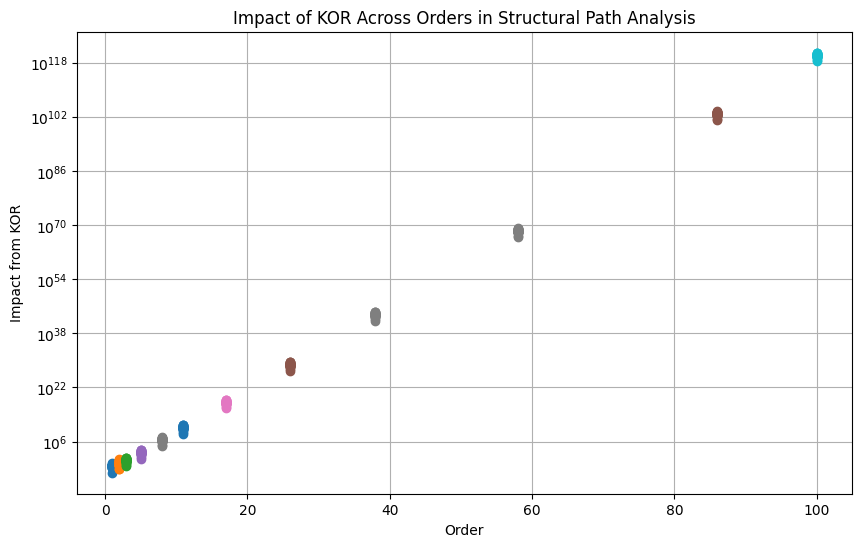

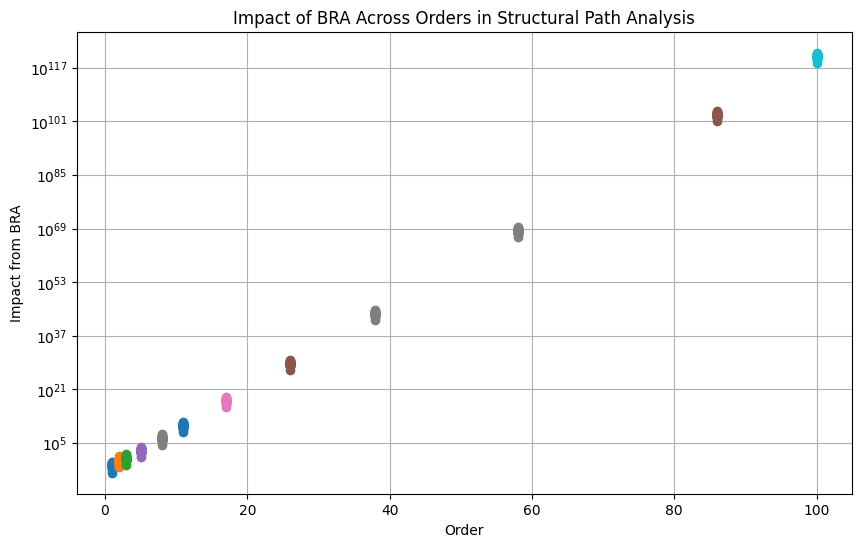

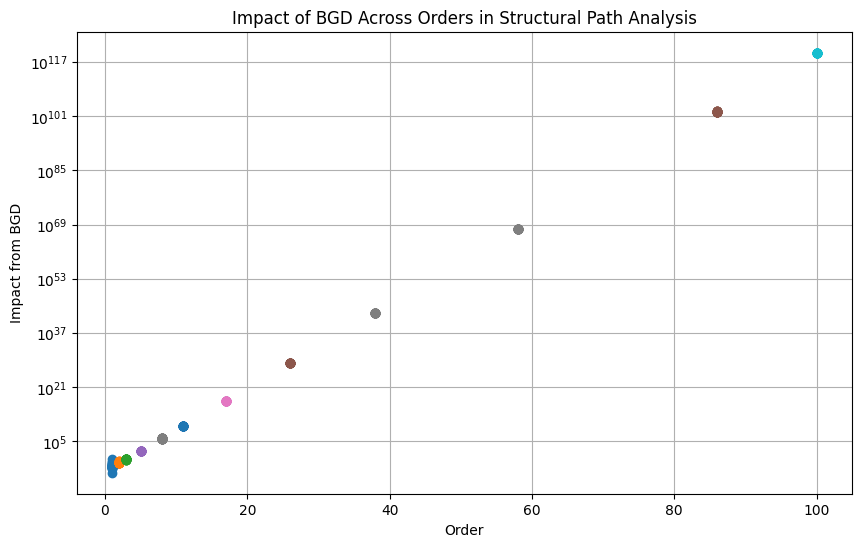

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# List of countries of interest
countries_of_interest = ["KOR", "BRA", "BGD"]
country_sector_labels = data['country_sector_labels']
paths_taylor = data['paths_taylor']

# Iterate over each country to plot its impact per order
for sector_of_interest in countries_of_interest:
    # Filter indices where the label starts with the country code (e.g., "KOR", "BRA", "BGD")
    indices_of_interest = [i for i, label in enumerate(country_sector_labels) if label.startswith(sector_of_interest)]

    # Initialize a dictionary to store the impact of each order separately
    order_impacts = {order: [] for order in range(1, 101)}

    for path in paths_taylor:
        order = path['order']
        path_values = path['path_values']

        # Store the impact for each order separately
        for index in indices_of_interest:
            if index < len(path_values):
                order_impacts[order].append(path_values[index])

    # Now plot the impacts for each order
    plt.figure(figsize=(10, 6))
    for order in sorted(order_impacts.keys()):
        impacts = order_impacts[order]
        plt.plot([order] * len(impacts), impacts, 'o', label=f'Order {order}')

    plt.xlabel('Order')
    plt.ylabel(f'Impact from {sector_of_interest}')
    plt.title(f'Impact of {sector_of_interest} Across Orders in Structural Path Analysis')
    plt.grid(True)
    plt.yscale('log')  # Using a logarithmic scale for better visualization if impacts vary widely
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# List of paths (indices) related to a specific sector/country you want to track
paths_to_track = ["KOR"]  # You can expand this list with other specific paths of interest

# Identify indices corresponding to the paths of interest
country_sector_labels = data['country_sector_labels']
indices_of_interest = [i for i, label in enumerate(country_sector_labels) if any(sector in label for sector in paths_to_track)]

# Initialize a dictionary to store the impact of each path across orders
tracked_paths = {index: [] for index in indices_of_interest}

# Iterate over each order and extract the impact for each tracked path
paths_taylor = data['paths_taylor']

for path in paths_taylor:
    order = path['order']
    path_values = path['path_values']

    # Store the impact for each tracked path at the current order
    for index in indices_of_interest:
        if index < len(path_values):
            tracked_paths[index].append(path_values[index])
        else:
            tracked_paths[index].append(0)  # If the index is out of bounds, assume impact is 0

# Plotting the impact of each tracked path across orders
plt.figure(figsize=(10, 6))
for index, impacts in tracked_paths.items():
    plt.plot(orders, impacts, marker='o', linestyle='-', label=country_sector_labels[index])

plt.xlabel('Order')
plt.ylabel('Impact')
plt.title('Impact of Selected Paths Across Orders in Structural Path Analysis')
plt.grid(True)
plt.yscale('log')  # Using a logarithmic scale for better visualization if impacts vary widely
plt.legend()
plt.show()


NameError: name 'orders' is not defined

<Figure size 1000x600 with 0 Axes>

**Previous SPA format**

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import zipfile

# Function to compute k-th power of matrix A efficiently
def matrix_power(A, k):
    result = np.eye(A.shape[0])  # Start with the identity matrix
    for _ in range(k):
        result = np.dot(result, A)  # Multiply by A, k times
    return result

# Function to compute structural path analysis using Taylor expansion
def structural_path_analysis_taylor(A, f, max_order=10, threshold=1e-5):
    paths = []
    I = np.eye(A.shape[0])

    # Calculate direct influence (first-order paths)
    path_values = f
    significant_paths = path_values[path_values > threshold]
    paths.append({'order': 1, 'path_values': significant_paths})  # Order 1 paths

    # Calculate higher-order paths using the Taylor series expansion
    current_power = A  # Start with A^1
    for k in range(2, max_order + 1):
        path_values = np.dot(current_power, f)
        significant_paths = path_values[path_values > threshold]
        paths.append({'order': k, 'path_values': significant_paths})  # Order k paths
        current_power = np.dot(current_power, A)  # Compute A^(k+1) for the next iteration

    return paths

# Define the analysis function
def perform_analysis(year):
    # Path to the ZIP file
    zip_file_path = f'/content/drive/MyDrive/Yannis/Eora26_All/Eora26_{year}_bp.zip'

    with zipfile.ZipFile(zip_file_path, 'r') as z:
        # Read specific files into DataFrames
        with z.open(f'Eora26_{year}_bp_T.txt') as file:
            Eora_pp_T = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_FD.txt') as file:
            Eora_pp_FD = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_VA.txt') as file:
            Eora_pp_VA = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_Q.txt') as file:
            Eora_pp_Q = pd.read_csv(file, sep='\t', header=None)

        with z.open(f'Eora26_{year}_bp_QY.txt') as file:
            Eora_pp_QY = pd.read_csv(file, sep='\t', header=None)

        # Also read the label files if needed
        with z.open('labels_T.txt') as file:
            labels_T = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_FD.txt') as file:
            labels_FD = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_VA.txt') as file:
            labels_VA = pd.read_csv(file, sep='\t', header=None)

        with z.open('labels_Q.txt') as file:
            labels_Q = pd.read_csv(file, sep='\t', header=None)

    # Filter Emissions Rows
    emission_indices = labels_Q[labels_Q.iloc[:, 0].str.contains(r"\(Gg\)") & ~labels_Q.iloc[:, 0].str.contains("Total")].index

    # Subset the Emissions Data
    Eora_pp_Q_emissions = Eora_pp_Q.iloc[emission_indices]

    # Transform data frames into matrices
    Eora_pp_T_matrix = Eora_pp_T.values
    Eora_pp_Q_emissions_matrix = Eora_pp_Q_emissions.values

    # Calculate total output
    xout = Eora_pp_T_matrix.sum(axis=0) + Eora_pp_FD.sum(axis=0)
    xout = np.where(xout == 0, 1e-10, xout)  # Avoid division by zero

    # Normalize the transaction matrix (T)
    A = Eora_pp_T_matrix / xout

    # Normalize the externalities (Q)
    f_matrix = Eora_pp_Q_emissions_matrix / xout

    # Sum across emissions to create a 1-dimensional vector
    f = f_matrix.sum(axis=0)

    # Perform structural path analysis using Taylor series method
    paths_taylor = structural_path_analysis_taylor(A, f, max_order=10, threshold=1e-5)

    # Flatten paths into a DataFrame for easier analysis
    all_paths_taylor = []
    for path in paths_taylor:
        k = path['order']
        path_values = path['path_values']
        for i, value in enumerate(path_values):
            all_paths_taylor.append({'Order': k, 'Path_Index': i, 'Impact': value})

    paths_df_taylor = pd.DataFrame(all_paths_taylor)

    # Extract sector labels based on the actual number of sectors
    num_sectors = len(f)
    sector_labels = labels_T.iloc[:num_sectors, 3].values
    country_labels = labels_T.iloc[:num_sectors, 1].values

    # Create country-specific sector labels
    country_sector_labels = [f"{country}_{sector}" for country, sector in zip(country_labels, sector_labels)]

    # Compute total impact for all sectors
    def compute_total_impact(L):
        total_impact = L.sum(axis=1)
        return total_impact

    # Calculate the Leontief Inverse Matrix
    I = np.eye(A.shape[0])  # Identity matrix
    L = np.linalg.inv(I - A)
    total_impact = compute_total_impact(L)

    # Create directed graph from the input-output matrix A
    def create_network(A, labels):
        G = nx.DiGraph()
        num_nodes = A.shape[0]
        for i in range(num_nodes):
            for j in range(num_nodes):
                if A[i, j] != 0:
                    G.add_edge(labels[i], labels[j], weight=A[i, j])
        return G

    def find_alpha_beta(G):
        # Get the adjacency matrix of the graph
        A = nx.to_numpy_array(G)
        # Calculate the largest eigenvalue
        largest_eigenvalue = max(np.linalg.eigvals(A))
        # Define alpha as a fraction of the reciprocal of the largest eigenvalue
        alpha = 0.1 * (1 / largest_eigenvalue)
        # Set beta to 1.0 (standard value)
        beta = 1.0
        return alpha, beta

    # Compute centrality measures
    def compute_centralities(G):
        eigenvector_centrality = nx.eigenvector_centrality_numpy(G)
        betweenness_centrality = nx.betweenness_centrality(G)
        degree_centrality = nx.degree_centrality(G)
        in_degree_centrality = nx.in_degree_centrality(G)  # For directed graphs
        out_degree_centrality = nx.out_degree_centrality(G)  # For directed graphs
        alpha, beta = find_alpha_beta(G)
        bonacich_centrality = nx.katz_centrality_numpy(G, alpha=alpha, beta=beta)

        return {
            'eigenvector': eigenvector_centrality,
            'betweenness': betweenness_centrality,
            'degree': degree_centrality,
            'in_degree': in_degree_centrality,
            'out_degree': out_degree_centrality,
            'bonacich': bonacich_centrality
        }

    # Create directed graph
    G = create_network(A, sector_labels)
    centrality = compute_centralities(G)

    # Prepare DataFrame with results
    df = pd.DataFrame({
        'Sector': sector_labels,
        'Country': country_labels,
        'Year': year,
        'Total Impact': total_impact,
        'Eigenvector Centrality': [centrality['eigenvector'][sector] for sector in sector_labels],
        'Bonacich Centrality': [centrality['bonacich'][sector] for sector in sector_labels],
        'Degree Centrality': [centrality['degree'][sector] for sector in sector_labels],
        'Betweenness Centrality': [centrality['betweenness'][sector] for sector in sector_labels],
        'In-Degree Centrality': [centrality['in_degree'][sector] for sector in sector_labels],
        'Out-Degree Centrality': [centrality['out_degree'][sector] for sector in sector_labels],
        'Country_Sector': country_sector_labels
    })

    # Flatten all paths for inclusion in the DataFrame
    for path in paths_taylor:
        order = path['order']
        df[f'Order_{order}_Paths'] = np.nan  # Initialize column for paths
        path_indices = paths_df_taylor[paths_df_taylor['Order'] == order]['Path_Index'].values
        impacts = paths_df_taylor[paths_df_taylor['Order'] == order]['Impact'].values
        for i, idx in enumerate(path_indices):
            df.loc[idx, f'Order_{order}_Paths'] = impacts[i]

    # Save all relevant variables for this year, including the databases
    variables_to_save = {
        'Eora_pp_FD': Eora_pp_FD,
        'labels_FD': labels_FD,
        'Eora_pp_Q': Eora_pp_Q,
        'labels_Q': labels_Q,
        'Eora_pp_QY': Eora_pp_QY,
        'Eora_pp_T': Eora_pp_T,
        'labels_T': labels_T,
        'Eora_pp_VA': Eora_pp_VA,
        'labels_VA': labels_VA,
        'Eora_pp_T_matrix': Eora_pp_T_matrix,
        'Eora_pp_Q_emissions_matrix': Eora_pp_Q_emissions_matrix,
        'xout': xout,
        'A': A,
        'f': f,
        'I': I,
        'L': L,
        'Direct Impact': paths_df_taylor[paths_df_taylor['Order'] == 1]['Impact'].values,
        'First-Order Indirect Impact': paths_df_taylor[paths_df_taylor['Order'] == 2]['Impact'].values,
        'Second-Order Indirect Impact': paths_df_taylor[paths_df_taylor['Order'] == 3]['Impact'].values,
        'paths_taylor': paths_taylor,  # Save all Taylor paths along with their orders
        'paths_df_taylor': paths_df_taylor,  # Save the flattened DataFrame for convenience
        'sector_labels': sector_labels,
        'country_labels': country_labels,
        'country_sector_labels': country_sector_labels,
        'total_impact': total_impact,
        'centrality': centrality,
        'bonacich_centrality': centrality['bonacich']
    }
    save_path = f'/content/drive/MyDrive/Yannis/variables_for_{year}.pkl'
    with open(save_path, 'wb') as file:
        pickle.dump(variables_to_save, file)

    return df

# Example usage:
years = range(1990, 2017)
results = pd.DataFrame()

for year in years:
    print(f"\nAnalysis for the year {year}:\n")
    year_df = perform_analysis(year)
    results = pd.concat([results, year_df])
    print(f'\nAnalysis for {year} saved in the drive')

# Save results to a CSV file
results.to_csv('/content/drive/MyDrive/Yannis/1990-2016_results_analysis.csv', index=False)

# Display the DataFrame
results.head()

# **SPA & Network Analysis**

---



Let's look how to best integrate the SPA to the Network analysis

The data is 15,5GO when my RAM has 12.7GB so I need to use ways to make it smaller, cut it into chunks.

Source
SUD_Finacial Intermediation and Business Activities          188.205714
SUD_Petroleum, Chemical and Non-Metallic Mineral Products     55.768141
SUD_Wholesale Trade                                           44.954799
SUD_Electrical and Machinery                                  42.463519
SDS_Finacial Intermediation and Business Activities           32.173170
SUD_Post and Telecommunications                               26.203658
SUD_Metal Products                                            25.895263
SUD_Wood and Paper                                            23.339165
SUD_Education, Health and Other Services                      18.141677
SUD_Transport                                                 18.058913
Name: GrowthRate, dtype: float64


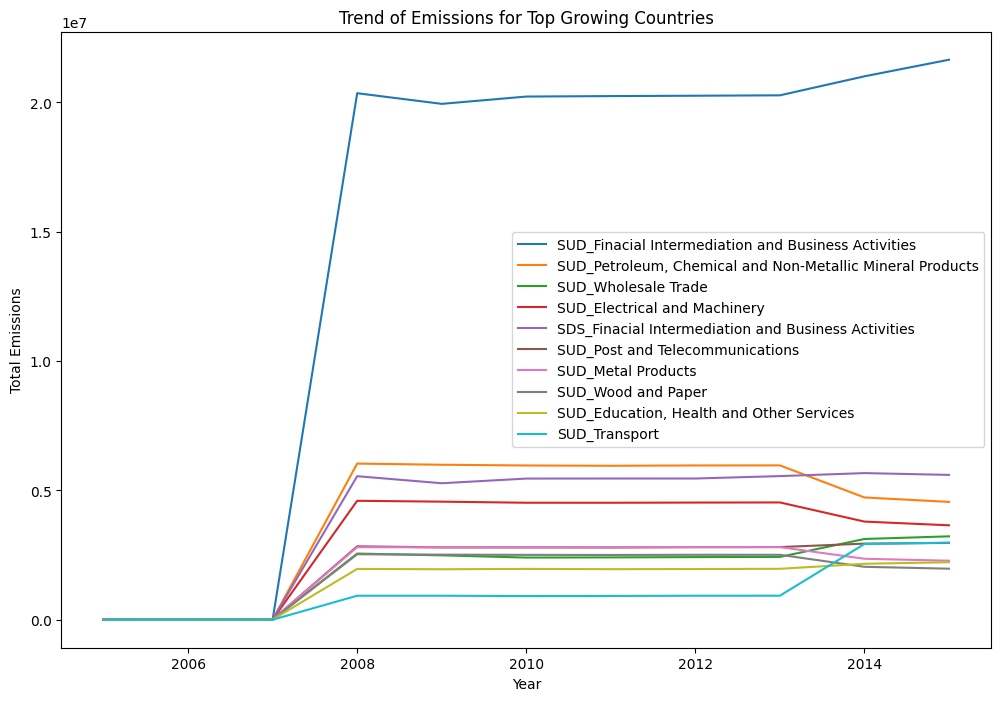

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the path to your large CSV file
large_file_path = '/content/drive/MyDrive/Yannis/all_years_emissions_data.csv'

# Initialize an empty DataFrame to store the processed data
country_yearly_emissions = pd.DataFrame()

# Process the data in chunks
chunksize = 10000  # Adjust this value based on your memory constraints
for chunk in pd.read_csv(large_file_path, chunksize=chunksize):
    # Calculate total emissions imported and exported by each country for each year in the chunk
    chunk_grouped = chunk.groupby(['Year', 'Source'])['Value'].sum().reset_index()
    country_yearly_emissions = pd.concat([country_yearly_emissions, chunk_grouped])

# Recalculate total emissions for each year after combining chunks
country_yearly_emissions = country_yearly_emissions.groupby(['Year', 'Source'])['Value'].sum().reset_index()

# Calculate growth rates for each country
country_growth = country_yearly_emissions.groupby('Source')['Value'].pct_change().fillna(0)

# Add growth rates to the dataframe
country_yearly_emissions['GrowthRate'] = country_growth

# Identify countries with highest growth rates
top_countries_growth = country_yearly_emissions.groupby('Source')['GrowthRate'].mean().sort_values(ascending=False).head(10)

print(top_countries_growth)

# Plot trend of top countries
plt.figure(figsize=(12, 8))
for country in top_countries_growth.index:
    country_data = country_yearly_emissions[country_yearly_emissions['Source'] == country]
    plt.plot(country_data['Year'], country_data['Value'], label=country)
plt.title('Trend of Emissions for Top Growing Countries')
plt.xlabel('Year')
plt.ylabel('Total Emissions')
plt.legend()
plt.show()


Ah, the data didn't compute well and I only have it from 2005 and 2015. It was from a previous test on only a few years. The dataset isn't very useful and the method too computationally costly. Let's give it up.
Instead, let's work on the results data and the paths.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Load the results DataFrame from the CSV file
results_df = pd.read_csv('/content/drive/MyDrive/Yannis/1990-2016_results_analysis.csv')

def load_paths_df_taylor(year):
    with open(f'/content/drive/MyDrive/Yannis/variables_for_{year}.pkl', 'rb') as file:
        year_data = pickle.load(file)
        # Access the paths_df_taylor variable
        paths_df_taylor = year_data['paths_df_taylor']
        return paths_df_taylor
    return year_data

# Initialize an empty dataframe to store it all
all_paths_df = pd.DataFrame()

for year in range(1990, 2016):
    print(f"\nAnalysis for the year {year}:\n")
    year_df = load_paths_df_taylor(year)
    all_paths_df = pd.concat([all_paths_df, year_df])

# Save the results to Google Drive
all_paths_df.to_csv('/content/drive/MyDrive/Yannis/all_paths_df.csv', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Analysis for the year 1990:


Analysis for the year 1991:


Analysis for the year 1992:


Analysis for the year 1993:


Analysis for the year 1994:


Analysis for the year 1995:


Analysis for the year 1996:


Analysis for the year 1997:


Analysis for the year 1998:


Analysis for the year 1999:


Analysis for the year 2000:


Analysis for the year 2001:


Analysis for the year 2002:


Analysis for the year 2003:


Analysis for the year 2004:


Analysis for the year 2005:


Analysis for the year 2006:


Analysis for the year 2007:


Analysis for the year 2008:


Analysis for the year 2009:


Analysis for the year 2010:


Analysis for the year 2011:


Analysis for the year 2012:


Analysis for the year 2013:


Analysis for the year 2014:


Analysis for the year 2015:



In [ ]:
#Load the paths
all_paths_df = pd.read_csv('/content/drive/MyDrive/Yannis/all_paths_df.csv')

In [ ]:
all_paths_df.shape()

# Analysis with emissions reduction

**Sectoral emissions reduction spread**

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import zipfile

# Function to load Eora26 data for a specific year
def load_eora26_data(year):
    file_path = f'/content/drive/MyDrive/Yannis/Eora26_All/Eora26_{year}_bp.zip'
    with zipfile.ZipFile(file_path, 'r') as z:
        T = pd.read_csv(z.open(f'Eora26_{year}_bp_T.txt'), sep='\t', header=None)
        FD = pd.read_csv(z.open(f'Eora26_{year}_bp_FD.txt'), sep='\t', header=None)
        Q = pd.read_csv(z.open(f'Eora26_{year}_bp_Q.txt'), sep='\t', header=None)
        QY = pd.read_csv(z.open(f'Eora26_{year}_bp_QY.txt'), sep='\t', header=None)
        labels_T = pd.read_csv(z.open('labels_T.txt'), sep='\t', header=None)
        labels_Q = pd.read_csv(z.open('labels_Q.txt'), sep='\t', header=None)
    return T, FD, Q, QY, labels_T, labels_Q

year = 1990
T, FD, Q, QY, labels_T, labels_Q = load_eora26_data(year)

labels_Q.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


0                          1   2
0  Energy Usage (TJ)                Natural Gas NaN
1  Energy Usage (TJ)                       Coal NaN
2  Energy Usage (TJ)                  Petroleum NaN
3  Energy Usage (TJ)        Nuclear Electricity NaN
4  Energy Usage (TJ)  Hydroelectric Electricity NaN

In [ ]:
year = 1990
T, FD, Q, QY, labels_T, labels_Q = load_eora26_data(year)
Q.head()

0          1         2          3         4          5         6     \
0  581.6070  25.795600  494.0920  2475.4600  440.7490  1247.2000  3049.970   
1   21.1418   0.937689   17.9606    89.9845   16.0215    45.3367   110.868   
2  236.1250  10.472700  200.5950  1005.0000  178.9380   506.3480  1238.250   
3    0.0000   0.000000    0.0000     0.0000    0.0000     0.0000     0.000   
4   65.1666   2.890290   55.3608   277.3640   49.3840   139.7440   341.736   

        7         8          9     ...      4905       4906      4907  \
0  1275.8000  3060.720  1631.6400  ...    0.1000     0.1000    0.1000   
1    46.3763   111.259    59.3114  ...  467.8650  5884.7300  391.1810   
2   517.9590  1242.610   662.4270  ...    2.3500     2.3500    2.3500   
3     0.0000     0.000     0.0000  ...    0.1000     0.1000    0.1000   
4   142.9480   342.940   182.8190  ...   13.5594    13.5594   13.5594   

        4908       4909       4910     4911     4912  4913  4914  
0     0.1000     0.1000     0.1000   0.1000   0.1000   0.0   0.0  
1  1764.6600  1668.5700  1577.7800  37.1000   1.7000   0.0   0.0  
2     2.3500     2.3500     2.3500   2.3500   2.3500   0.0   0.0  
3     0.1000     0.1000     0.1000   0.1000   0.1000   0.0   0.0  
4    13.5594    13.5594    13.5594  13.5594  13.5594   0.0   0.0  

[5 rows x 4915 columns]

In [ ]:
# Display the first few rows of labels_Q to understand its structure
print('Head\n',labels_Q.head())

# Display the column names and types
print('\nColumn\n',labels_Q.columns)

sector_column = labels_Q.iloc[:, 1]
sector_index = sector_column[sector_column == sector_name].index[1]
print('\nSector Column\n', sector_index)

Head
                    0                          1   2
0  Energy Usage (TJ)                Natural Gas NaN
1  Energy Usage (TJ)                       Coal NaN
2  Energy Usage (TJ)                  Petroleum NaN
3  Energy Usage (TJ)        Nuclear Electricity NaN
4  Energy Usage (TJ)  Hydroelectric Electricity NaN

Column
 Index([0, 1, 2], dtype='int64')

Sector Column
 0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import zipfile

# Function to load Eora26 data for a specific year
def load_eora26_data(year):
    file_path = f'/content/drive/MyDrive/Yannis/Eora26_All/Eora26_{year}_bp.zip'
    with zipfile.ZipFile(file_path, 'r') as z:
        T = pd.read_csv(z.open(f'Eora26_{year}_bp_T.txt'), sep='\t', header=None)
        FD = pd.read_csv(z.open(f'Eora26_{year}_bp_FD.txt'), sep='\t', header=None)
        Q = pd.read_csv(z.open(f'Eora26_{year}_bp_Q.txt'), sep='\t', header=None)
        QY = pd.read_csv(z.open(f'Eora26_{year}_bp_QY.txt'), sep='\t', header=None)
        labels_T = pd.read_csv(z.open('labels_T.txt'), sep='\t', header=None)
        labels_Q = pd.read_csv(z.open('labels_Q.txt'), sep='\t', header=None)
    return T, FD, Q, QY, labels_T, labels_Q

# Function to apply emission reduction to a specific sector
def apply_emission_reduction(Q, labels_Q, sector_name, reduction_factor):
    # Inspect the structure of labels_Q
    print(labels_Q.head())

    # Find the correct index of the sector name column
    sector_column = labels_Q.iloc[:, 1]
    print(f"Searching for sector '{sector_name}' in the following column:")
    print(sector_column.head())

    if sector_name in sector_column.values:
        sector_index = sector_column[sector_column == sector_name].index[0]
        print(f"Sector '{sector_name}' found at index {sector_index}. Applying reduction.")
        Q.iloc[:, sector_index] *= reduction_factor
    else:
        print(f"Sector '{sector_name}' not found in labels_Q.")
    return Q

# Function to compute k-th power of matrix A efficiently
def matrix_power(A, k):
    result = np.eye(A.shape[0])  # Start with the identity matrix
    for _ in range(k):
        result = np.dot(result, A)  # Multiply by A, k times
    return result

# Function to compute structural path analysis using Taylor expansion
def structural_path_analysis_taylor(A, f, max_order=10, threshold=1e-5):
    paths = []
    I = np.eye(A.shape[0])

    # Calculate direct influence (first-order paths)
    path_values = f
    significant_paths = path_values[path_values > threshold]
    paths.append({'order': 1, 'path_values': significant_paths})  # Order 1 paths

    # Calculate higher-order paths using the Taylor series expansion
    current_power = A  # Start with A^1
    for k in range(2, max_order + 1):
        path_values = np.dot(current_power, f)
        significant_paths = path_values[path_values > threshold]
        paths.append({'order': k, 'path_values': significant_paths})  # Order k paths
        current_power = np.dot(current_power, A)  # Compute A^(k+1) for the next iteration

    return paths

# Function to compute Leontief Inverse and SPA paths
def compute_leontief_inverse_and_spa(T, Q):
    xout = T.sum(axis=0)
    xout = np.where(xout == 0, 1e-10, xout)  # Avoid division by zero
    A = T / xout

    # Normalize the environmental extension matrix
    f_matrix = Q / xout
    f = f_matrix.sum(axis=0)

    # Calculate the Leontief inverse
    I = np.eye(A.shape[0])
    L = np.linalg.inv(I - A)

    # Perform structural path analysis (SPA) using Taylor series method
    paths_taylor = structural_path_analysis_taylor(A, f, max_order=10, threshold=1e-5)

    return L, paths_taylor

# Example usage
year = 1990
T, FD, Q, QY, labels_T, labels_Q = load_eora26_data(year)

# Apply 20% reduction in emissions for the 'Electrical and Machinery' sector
reduction_factor = 0.8
sector_name = 'Electrical and Machinery'
Q_reduced = apply_emission_reduction(Q, labels_Q, sector_name, reduction_factor)

# Compute Leontief inverse and SPA paths for original and reduced emissions
L_original, paths_original = compute_leontief_inverse_and_spa(T, Q)
L_reduced, paths_reduced = compute_leontief_inverse_and_spa(T, Q_reduced)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                   0                          1   2
0  Energy Usage (TJ)                Natural Gas NaN
1  Energy Usage (TJ)                       Coal NaN
2  Energy Usage (TJ)                  Petroleum NaN
3  Energy Usage (TJ)        Nuclear Electricity NaN
4  Energy Usage (TJ)  Hydroelectric Electricity NaN
Searching for sector 'Electrical and Machinery' in the following column:
0                  Natural Gas
1                         Coal
2                    Petroleum
3          Nuclear Electricity
4    Hydroelectric Electricity
Name: 1, dtype: object
Sector 'Electrical and Machinery' not found in labels_Q.


In [ ]:
# Function to compare original and reduced SPA impacts
def compare_spa_impacts(paths_original, paths_reduced, sector_name, labels_T):
    sector_column = labels_T.iloc[:, 3]  # The column containing sector names
    if sector_name in sector_column.values:
        sector_index = sector_column[sector_column == sector_name].index[0]

        impacts_original = []
        for path in paths_original:
            if len(path['path_values']) > sector_index:
                impacts_original.append(path['path_values'][sector_index])

        impacts_reduced = []
        for path in paths_reduced:
            if len(path['path_values']) > sector_index:
                impacts_reduced.append(path['path_values'][sector_index])

        return impacts_original, impacts_reduced
    else:
        print(f"Sector '{sector_name}' not found in labels_T.")
        return [], []

# Compare SPA impacts for the 'Electrical and Machinery' sector
sector_name = 'Electrical and Machinery'
impacts_original, impacts_reduced = compare_spa_impacts(paths_original, paths_reduced, sector_name, labels_T)

print("Original SPA Impacts:", impacts_original)
print("Reduced SPA Impacts:", impacts_reduced)
Impact_difference = np.array(impacts_original) - np.array(impacts_reduced)
print('Difference', Impact_difference)

Original SPA Impacts: [4.884492928816756, 323.46639256241826, 776.7614106400795, 1133.0422736922012, 1361.0233985391258, 1481.679350190518, 1527.7830009317727, 1526.9952319086847, 1498.6882001608712, 1455.2333000680242]
Reduced SPA Impacts: [4.884492928816756, 323.46639256241826, 776.7614106400795, 1133.0422736922012, 1361.0233985391258, 1481.679350190518, 1527.7830009317727, 1526.9952319086847, 1498.6882001608712, 1455.2333000680242]
Difference [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
print('Sectors names',labels_T.iloc[:,3].unique())

Sectors names ['Agriculture' 'Fishing' 'Mining and Quarrying' 'Food & Beverages'
 'Textiles and Wearing Apparel' 'Wood and Paper'
 'Petroleum, Chemical and Non-Metallic Mineral Products' 'Metal Products'
 'Electrical and Machinery' 'Transport Equipment' 'Other Manufacturing'
 'Recycling' 'Electricity, Gas and Water' 'Construction'
 'Maintenance and Repair' 'Wholesale Trade' 'Retail Trade'
 'Hotels and Restraurants' 'Transport' 'Post and Telecommunications'
 'Finacial Intermediation and Business Activities' 'Public Administration'
 'Education, Health and Other Services' 'Private Households' 'Others'
 'Re-export & Re-import' 'TOTAL']


**DEBUG SESSION**

---



In [ ]:
import pandas as pd
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import zipfile

from google.colab import drive
drive.mount('/content/drive')

# Function to load Eora26 data for a specific year
def load_eora26_data(year):
    file_path = f'/content/drive/MyDrive/Yannis/Eora26_All/Eora26_{year}_bp.zip'
    with zipfile.ZipFile(file_path, 'r') as z:
        T = pd.read_csv(z.open(f'Eora26_{year}_bp_T.txt'), sep='\t', header=None)
        FD = pd.read_csv(z.open(f'Eora26_{year}_bp_FD.txt'), sep='\t', header=None)
        Q = pd.read_csv(z.open(f'Eora26_{year}_bp_Q.txt'), sep='\t', header=None)
        QY = pd.read_csv(z.open(f'Eora26_{year}_bp_QY.txt'), sep='\t', header=None)
        labels_T = pd.read_csv(z.open('labels_T.txt'), sep='\t', header=None)
        labels_Q = pd.read_csv(z.open('labels_Q.txt'), sep='\t', header=None)
    return T, FD, Q, QY, labels_T, labels_Q

# Function to apply emission reduction to a specific sector
def apply_emission_reduction(T, Q, labels_T, sector_name, reduction_factor):
    # Find the sector indices in the transaction matrix labels
    sector_indices_T = labels_T[labels_T.iloc[:, 3] == sector_name].index.tolist()

    # Apply reduction to the corresponding columns in T and Q
    for sector_index in sector_indices_T:
        if sector_index < T.shape[1] and sector_index < Q.shape[1]:  # Ensure within bounds
            Q.iloc[:, sector_index] *= reduction_factor
    return Q

# Example usage
year = 1990
T, FD, Q, QY, labels_T, labels_Q = load_eora26_data(year)

# Apply 50% reduction in emissions for the 'Electrical and Machinery' sector
reduction_factor = 0.5
sector_name = 'Electrical and Machinery'
Q_reduced = apply_emission_reduction(T, Q.copy(), labels_T, sector_name, reduction_factor)

# Function to compute Leontief Inverse and SPA paths
def compute_leontief_inverse_and_spa(T, Q):
    xout = T.sum(axis=0)
    xout = np.where(xout == 0, 1e-10, xout)  # Avoid division by zero
    A = T / xout

    # Normalize the environmental extension matrix
    f_matrix = Q / xout
    f = f_matrix.sum(axis=0)

    # Calculate the Leontief inverse
    I = np.eye(A.shape[0])
    L = np.linalg.inv(I - A)

    # Perform structural path analysis (SPA) using Taylor series method
    paths_taylor = structural_path_analysis_taylor(A, f, max_order=10, threshold=1e-5)

    return L, paths_taylor

# Define structural path analysis using Taylor expansion
def structural_path_analysis_taylor(A, f, max_order=10, threshold=1e-5):
    paths = []
    I = np.eye(A.shape[0])

    # Calculate direct influence (first-order paths)
    path_values = f
    significant_paths = path_values[path_values > threshold]
    paths.append({'order': 1, 'path_values': significant_paths})  # Order 1 paths

    # Calculate higher-order paths using the Taylor series expansion
    current_power = A  # Start with A^1
    for k in range(2, max_order + 1):
        path_values = np.dot(current_power, f)
        significant_paths = path_values[path_values > threshold]
        paths.append({'order': k, 'path_values': significant_paths})  # Order k paths
        current_power = np.dot(current_power, A)  # Compute A^(k+1) for the next iteration

    return paths

# Function to compare original and reduced SPA impacts
def compare_spa_impacts(paths_original, paths_reduced, sector_indices):
    impacts_original = []
    impacts_reduced = []

    # Filter out-of-bound indices
    valid_indices = [i for i in sector_indices if i < len(paths_original[0]['path_values'])]

    for path in paths_original:
        if path['order'] > 0:  # Only consider valid paths
            impacts_original.append(np.sum(path['path_values'][valid_indices]))
    for path in paths_reduced:
        if path['order'] > 0:  # Only consider valid paths
            impacts_reduced.append(np.sum(path['path_values'][valid_indices]))

    return impacts_original, impacts_reduced

# Recompute impacts with reduced threshold
L_original, paths_original = compute_leontief_inverse_and_spa(T, Q)
L_reduced, paths_reduced = compute_leontief_inverse_and_spa(T, Q_reduced)

# Find the indices for 'Electrical and Machinery' sector in T
sector_indices = labels_T[labels_T.iloc[:, 3] == sector_name].index.tolist()
print(f"Indices for sector '{sector_name}' in T:", sector_indices)

# Compare SPA impacts for the identified sector
impacts_original, impacts_reduced = compare_spa_impacts(paths_original, paths_reduced, sector_indices)

print("Original SPA Impacts:", impacts_original)
print("Reduced SPA Impacts:", impacts_reduced)
print("Difference:", np.array(impacts_original) - np.array(impacts_reduced))

Mounted at /content/drive
Indices for sector 'Electrical and Machinery' in T: [8, 34, 60, 86, 112, 138, 164, 190, 216, 242, 268, 294, 320, 346, 372, 398, 424, 450, 476, 502, 528, 554, 580, 606, 632, 658, 684, 710, 736, 762, 788, 814, 840, 866, 892, 918, 944, 970, 996, 1022, 1048, 1074, 1100, 1126, 1152, 1178, 1204, 1230, 1256, 1282, 1308, 1334, 1360, 1386, 1412, 1438, 1464, 1490, 1516, 1542, 1568, 1594, 1620, 1646, 1672, 1698, 1724, 1750, 1776, 1802, 1828, 1854, 1880, 1906, 1932, 1958, 1984, 2010, 2036, 2062, 2088, 2114, 2140, 2166, 2192, 2218, 2244, 2270, 2296, 2322, 2348, 2374, 2400, 2426, 2452, 2478, 2504, 2530, 2556, 2582, 2608, 2634, 2660, 2686, 2712, 2738, 2764, 2790, 2816, 2842, 2868, 2894, 2920, 2946, 2972, 2998, 3024, 3050, 3076, 3102, 3128, 3154, 3180, 3206, 3232, 3258, 3284, 3310, 3336, 3362, 3388, 3414, 3440, 3466, 3492, 3518, 3544, 3570, 3596, 3622, 3648, 3674, 3700, 3726, 3752, 3778, 3804, 3830, 3856, 3882, 3908, 3934, 3960, 3986, 4012, 4038, 4064, 4090, 4116, 4142, 4168,

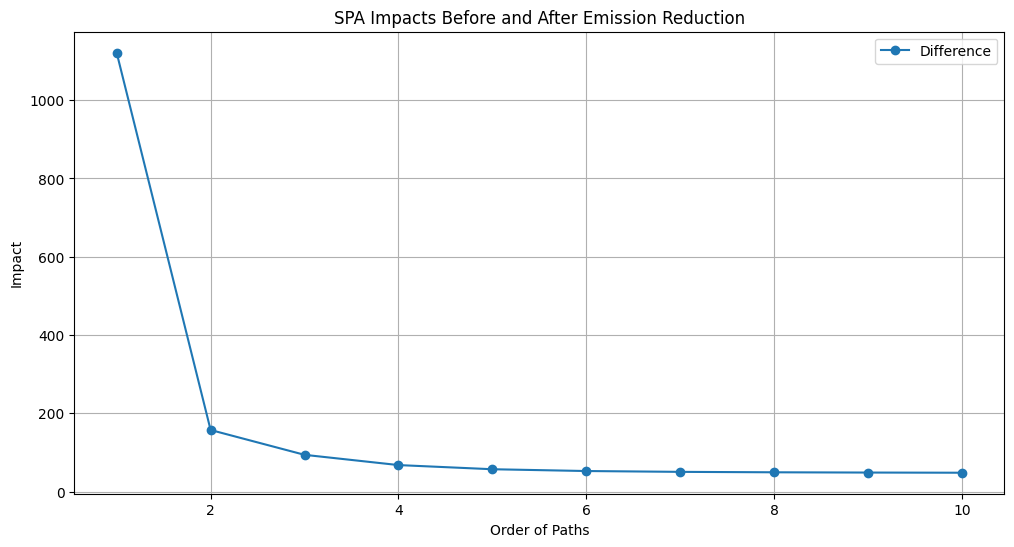

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Orders of paths
orders = range(1, 11)

# Plot the impacts
plt.figure(figsize=(12, 6))
plt.plot(orders, np.array(impacts_original) - np.array(impacts_reduced), label='Difference', marker='o')

# Add titles and labels
plt.title('SPA Impacts Before and After Emission Reduction')
plt.xlabel('Order of Paths')
plt.ylabel('Impact')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


**Trend Analysis:**

---



The plot shows a steep decline in the difference between the original and reduced impacts from the first to the second order.
The subsequent orders exhibit a relatively minor difference in impacts, suggesting that the indirect effects of the emission reduction become less significant as the paths get longer.
Implications:

The emission reduction in the 'Electrical and Machinery' sector primarily affects the direct and immediate interactions within the input-output network.
The propagation of the emission reduction through indirect and more complex relationships (higher-order paths) is minimal, indicating that the impact of emission reductions diminishes quickly beyond the direct effects.

**Multiple Sectors analysis**

---



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import zipfile

def load_eora26_data(year):
    with zipfile.ZipFile(f'/content/drive/MyDrive/Yannis/Eora26_All/Eora26_{year}_bp.zip', 'r') as z:
        with z.open(f'Eora26_{year}_bp_T.txt') as file:
            Eora_pp_T = pd.read_csv(file, sep='\t', header=None)
        with z.open(f'Eora26_{year}_bp_FD.txt') as file:
            Eora_pp_FD = pd.read_csv(file, sep='\t', header=None)
        with z.open(f'Eora26_{year}_bp_VA.txt') as file:
            Eora_pp_VA = pd.read_csv(file, sep='\t', header=None)
        with z.open(f'Eora26_{year}_bp_Q.txt') as file:
            Eora_pp_Q = pd.read_csv(file, sep='\t', header=None)
        with z.open(f'Eora26_{year}_bp_QY.txt') as file:
            Eora_pp_QY = pd.read_csv(file, sep='\t', header=None)
        with z.open('labels_T.txt') as file:
            labels_T = pd.read_csv(file, sep='\t', header=None)
        with z.open('labels_FD.txt') as file:
            labels_FD = pd.read_csv(file, sep='\t', header=None)
        with z.open('labels_VA.txt') as file:
            labels_VA = pd.read_csv(file, sep='\t', header=None)
        with z.open('labels_Q.txt') as file:
            labels_Q = pd.read_csv(file, sep='\t', header=None)
    return Eora_pp_T, Eora_pp_FD, Eora_pp_Q, Eora_pp_QY, labels_T, labels_Q

def structural_path_analysis_taylor(A, f, max_order=10, threshold=1e-5):
    paths = []
    I = np.eye(A.shape[0])
    path_values = f
    significant_paths = path_values[path_values > threshold]
    paths.append({'order': 1, 'path_values': significant_paths})
    current_power = A
    for k in range(2, max_order + 1):
        path_values = np.dot(current_power, f)
        significant_paths = path_values[path_values > threshold]
        paths.append({'order': k, 'path_values': significant_paths})
        current_power = np.dot(current_power, A)
    return paths

def apply_emission_reduction(T, Q, labels_T, sector_name, reduction_factor):
    sector_indices_T = labels_T[labels_T.iloc[:, 3] == sector_name].index.tolist()
    for sector_index in sector_indices_T:
        if sector_index < T.shape[1] and sector_index < Q.shape[1]:
            Q.iloc[:, sector_index] *= reduction_factor
    return Q

def compute_leontief_inverse_and_spa(T, Q):
    xout = T.sum(axis=0)
    xout = np.where(xout == 0, 1e-10, xout)
    A = T / xout
    f_matrix = Q / xout
    f = f_matrix.sum(axis=0)
    I = np.eye(A.shape[0])
    L = np.linalg.inv(I - A)
    paths_taylor = structural_path_analysis_taylor(A, f, max_order=10, threshold=1e-5)
    return L, paths_taylor

def compare_spa_impacts(paths_original, paths_reduced, sector_indices):
    impacts_original = []
    impacts_reduced = []
    valid_indices = [i for i in sector_indices if i < len(paths_original[0]['path_values'])]
    for path in paths_original:
        if path['order'] > 0:
            impacts_original.append(np.sum(path['path_values'][valid_indices]))
    for path in paths_reduced:
        if path['order'] > 0:
            impacts_reduced.append(np.sum(path['path_values'][valid_indices]))
    return impacts_original, impacts_reduced


In [ ]:
sectors_to_analyze = ['Electrical and Machinery', 'Agriculture', 'Transport']

results = []

for year in range(1990, 1996):
    print(f"Processing year {year}")
    T, FD, Q, QY, labels_T, labels_Q = load_eora26_data(year)
    for sector in sectors_to_analyze:
        reduction_factor = 0.5
        Q_reduced = apply_emission_reduction(T, Q.copy(), labels_T, sector, reduction_factor)
        L_original, paths_original = compute_leontief_inverse_and_spa(T, Q)
        L_reduced, paths_reduced = compute_leontief_inverse_and_spa(T, Q_reduced)
        sector_indices = labels_T[labels_T.iloc[:, 3] == sector].index.tolist()
        impacts_original, impacts_reduced = compare_spa_impacts(paths_original, paths_reduced, sector_indices)
        results.append({
            'Year': year,
            'Sector': sector,
            'Original Impact': impacts_original,
            'Reduced Impact': impacts_reduced,
            'Difference': np.array(impacts_original) - np.array(impacts_reduced)
        })
        print(f"Processed year {year} and sector {sector}")

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results)

# Save results to a CSV file
results_df.to_csv('/content/drive/MyDrive/Yannis/1990-1995_sector_impact_analysis.csv', index=False)


Processing year 1990
Processed year 1990 and sector Electrical and Machinery
Processed year 1990 and sector Agriculture
Processed year 1990 and sector Transport
Processing year 1991
Processed year 1991 and sector Electrical and Machinery
Processed year 1991 and sector Agriculture
Processed year 1991 and sector Transport
Processing year 1992
Processed year 1992 and sector Electrical and Machinery
Processed year 1992 and sector Agriculture
Processed year 1992 and sector Transport
Processing year 1993
Processed year 1993 and sector Electrical and Machinery
Processed year 1993 and sector Agriculture
Processed year 1993 and sector Transport
Processing year 1994
Processed year 1994 and sector Electrical and Machinery
Processed year 1994 and sector Agriculture
Processed year 1994 and sector Transport
Processing year 1995
Processed year 1995 and sector Electrical and Machinery
Processed year 1995 and sector Agriculture
Processed year 1995 and sector Transport


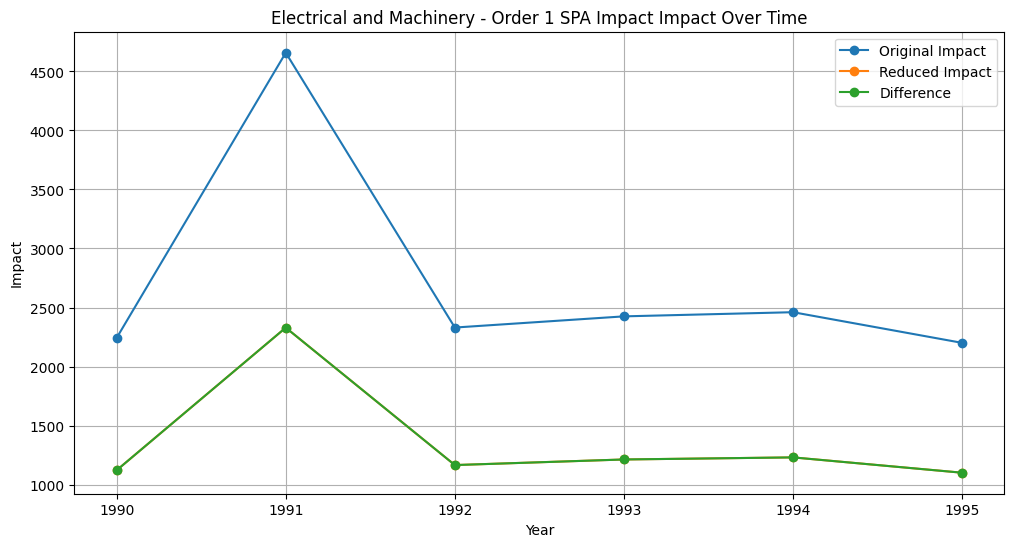

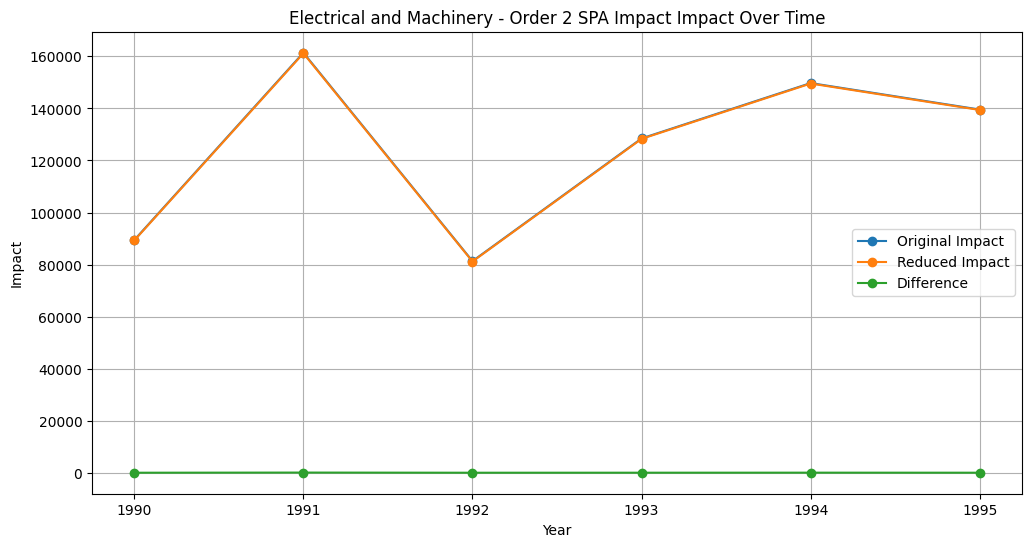

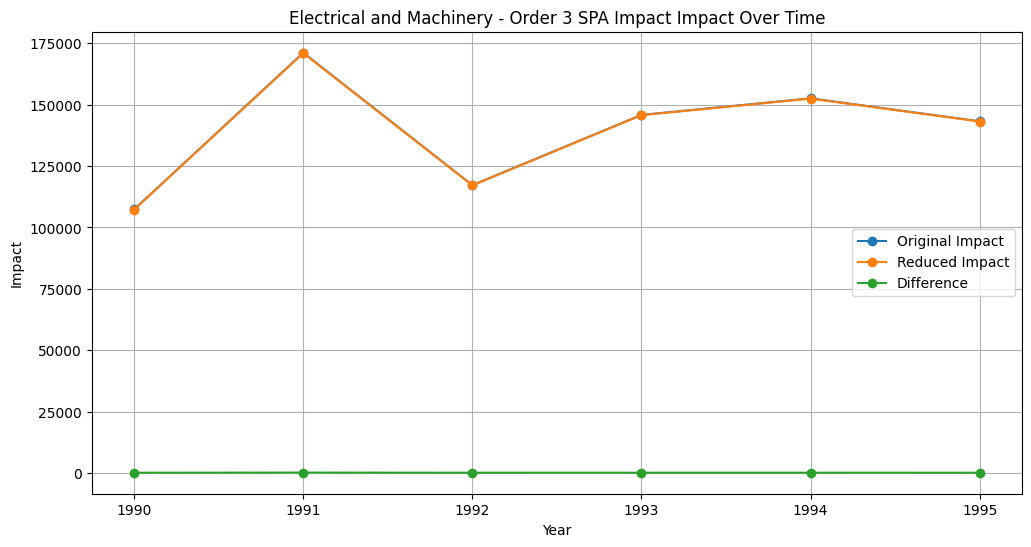

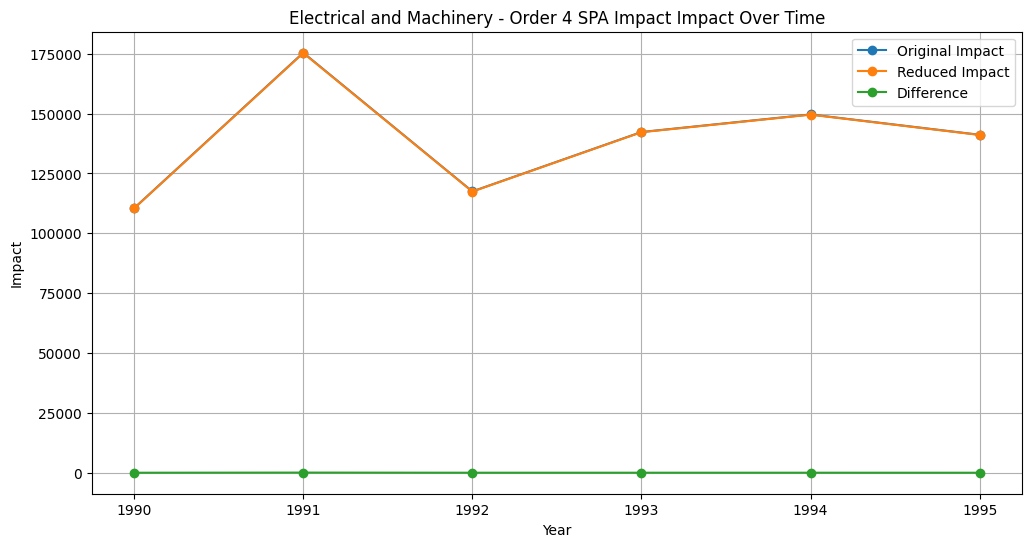

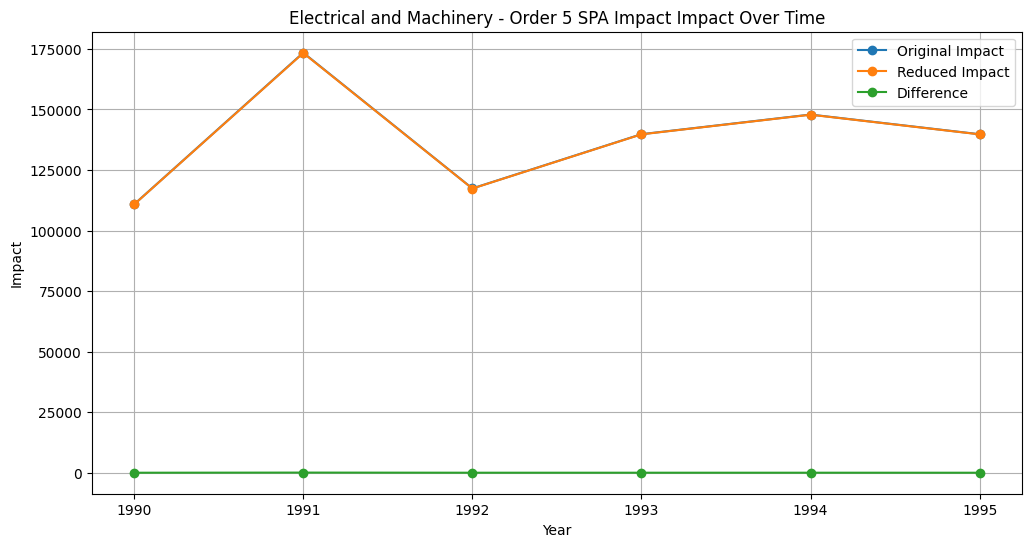

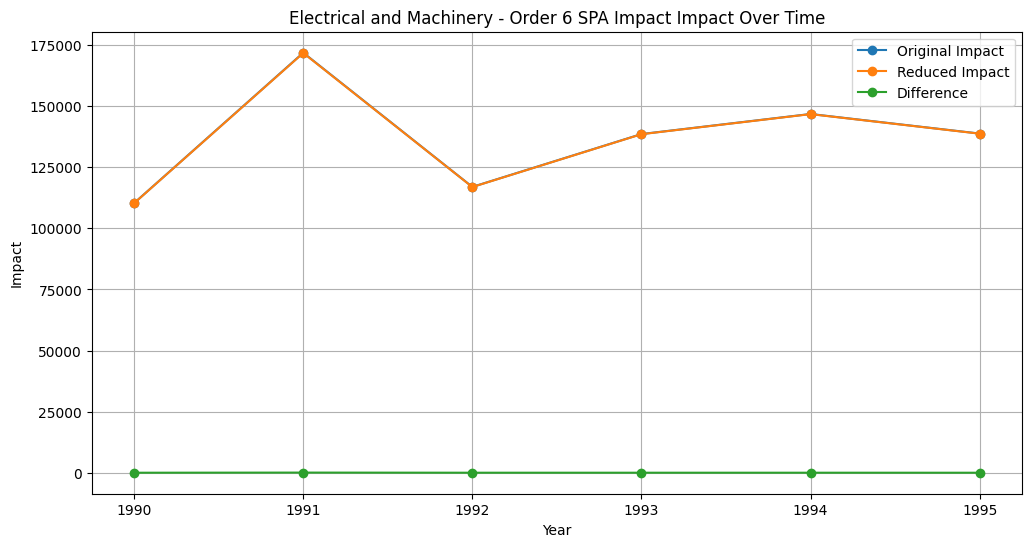

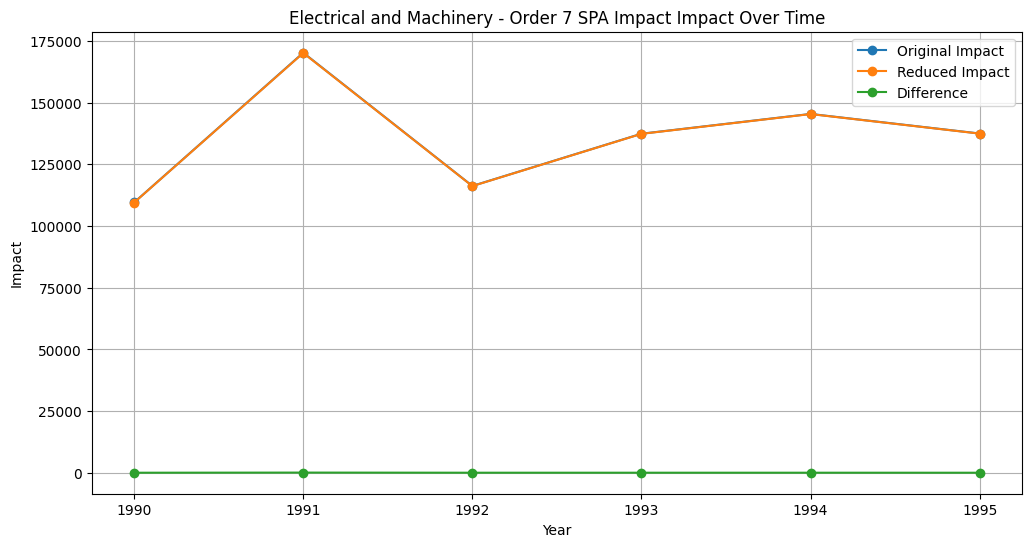

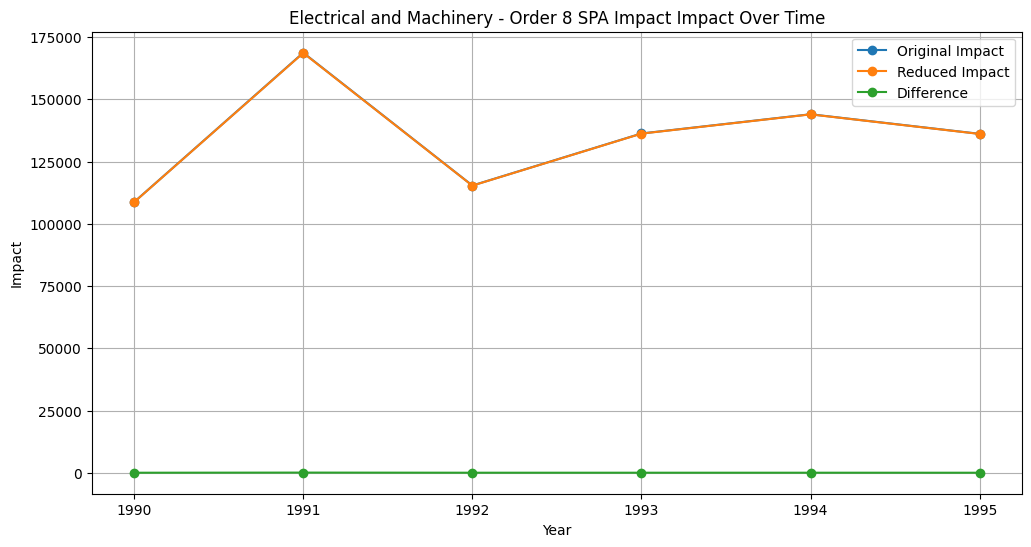

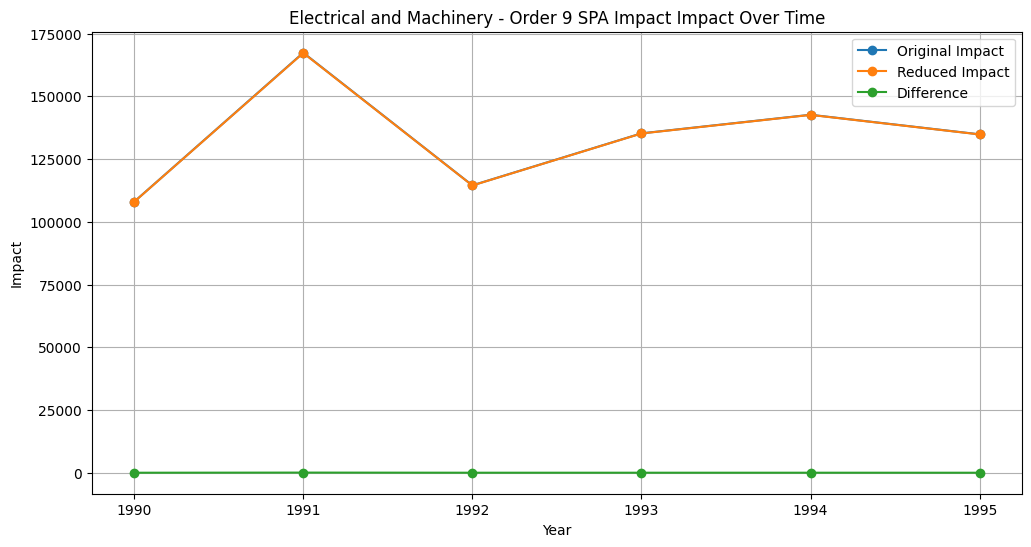

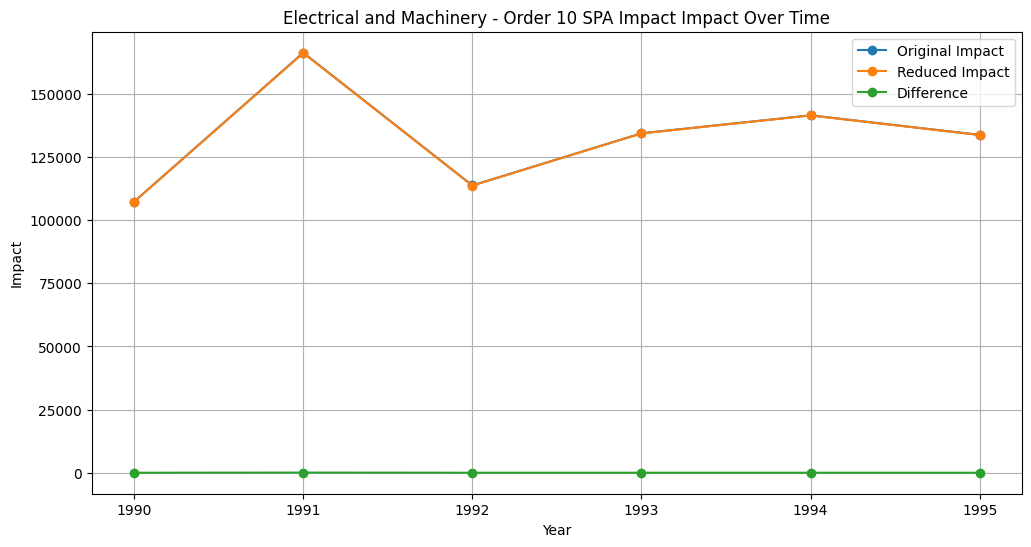

In [ ]:
import seaborn as sns

# Function to plot SPA impacts
def plot_spa_impacts(results_df, sector, measure):
    sector_data = results_df[results_df['Sector'] == sector]
    for order in range(10):
        plt.figure(figsize=(12, 6))
        plt.plot(sector_data['Year'], sector_data['Original Impact'].apply(lambda x: x[order]), label='Original Impact', marker='o')
        plt.plot(sector_data['Year'], sector_data['Reduced Impact'].apply(lambda x: x[order]), label='Reduced Impact', marker='o')
        plt.plot(sector_data['Year'], sector_data['Difference'].apply(lambda x: x[order]), label='Difference', marker='o')
        plt.title(f'{sector} - Order {order+1} SPA Impact {measure} Over Time')
        plt.xlabel('Year')
        plt.ylabel('Impact')
        plt.legend()
        plt.grid(True)
        plt.show()

# Example usage to plot impacts for 'Electrical and Machinery'
plot_spa_impacts(results_df, 'Electrical and Machinery', 'Impact')


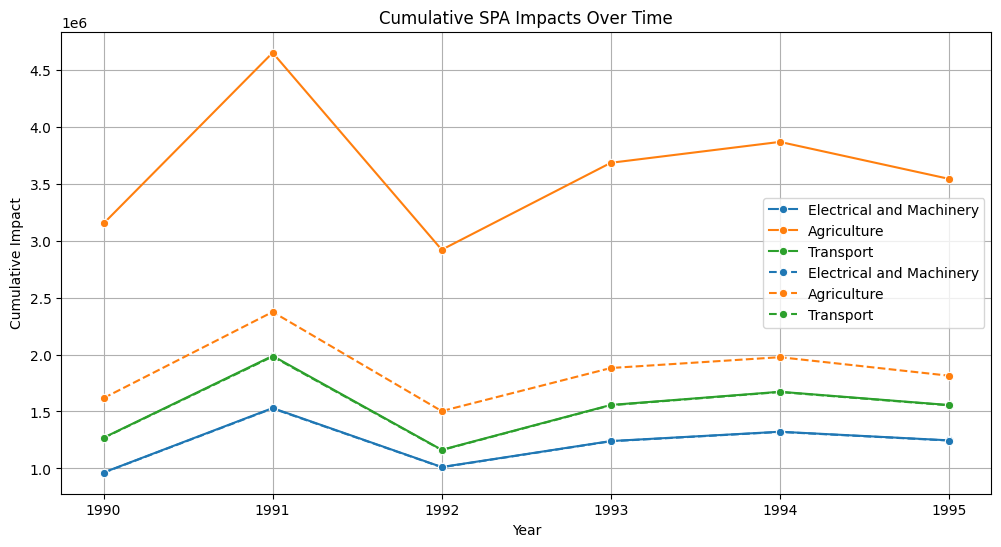

In [ ]:
# Function to compute cumulative impact reductions
def compute_cumulative_reductions(results_df, measure):
    results_df['Cumulative Original Impact'] = results_df['Original Impact'].apply(np.sum)
    results_df['Cumulative Reduced Impact'] = results_df['Reduced Impact'].apply(np.sum)
    results_df['Cumulative Difference'] = results_df['Difference'].apply(np.sum)
    return results_df

# Compute cumulative reductions
results_df = compute_cumulative_reductions(results_df, 'Impact')

# Plot cumulative reductions
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='Year', y='Cumulative Original Impact', hue='Sector', marker='o', palette='tab10')
sns.lineplot(data=results_df, x='Year', y='Cumulative Reduced Impact', hue='Sector', marker='o', linestyle='--', palette='tab10')
plt.title('Cumulative SPA Impacts Over Time')
plt.xlabel('Year')
plt.ylabel('Cumulative Impact')
plt.legend()
plt.grid(True)
plt.show()


**Now the hardest : Quantify and analyze sector Interdependencies**

---



Ok, in order to find the specific impact of a sector on another one, we can do so by analyzing the SPA paths and comparing the original and reduced impacts over multiple years. It helps understand the interdependencies between sectors and the propagation of emission reductions through the economy.

First, the function analyze_interdependencies iterates over the paths and checks if the 'Electrical and Machinery' sector is included in each path. It then aggregates the impacts for each sector. So, what we need to do first is initializing a dictionary to store the impacts. For each path, it checks if any of the sector indices is present in the path. If so, it adds the path value to the corresponding sector's total impact. Very buggy sometimes but it works !

The function compare_interdependencies calls analyze_interdependencies to get the impacts for both the original and reduced scenarios (50% decrease!).

In [ ]:
import numpy as np
import pandas as pd

def analyze_interdependencies(paths, sector_indices, labels_T):
    # Initialize a dictionary to store the impacts
    impacts = {sector: 0 for sector in labels_T.iloc[:, 3].unique()}

    # Analyze each path to quantify the impact of the specified sector
    for path in paths:
        order = path['order']
        path_values = path['path_values']
        for idx, value in enumerate(path_values):
            # Check if the path includes the sector of interest
            if any(sector_idx in path for sector_idx in sector_indices):
                sector_name = labels_T.iloc[idx, 3]
                impacts[sector_name] += value

    return impacts

def compare_interdependencies(paths_original, paths_reduced, sector_indices, labels_T):
    impacts_original = analyze_interdependencies(paths_original, sector_indices, labels_T)
    impacts_reduced = analyze_interdependencies(paths_reduced, sector_indices, labels_T)

    # Calculate the differences in impacts
    impact_differences = {sector: impacts_original[sector] - impacts_reduced[sector] for sector in impacts_original}

    return impacts_original, impacts_reduced, impact_differences

# Example usage
sectors_to_analyze = ['Electrical and Machinery']
results = []

for year in range(1990, 1996):
    print(f"Processing year {year}")
    T, FD, Q, QY, labels_T, labels_Q = load_eora26_data(year)
    for sector in sectors_to_analyze:
        reduction_factor = 0.5
        Q_reduced = apply_emission_reduction(T, Q.copy(), labels_T, sector, reduction_factor)
        L_original, paths_original = compute_leontief_inverse_and_spa(T, Q)
        L_reduced, paths_reduced = compute_leontief_inverse_and_spa(T, Q_reduced)
        sector_indices = labels_T[labels_T.iloc[:, 3] == sector].index.tolist()
        impacts_original, impacts_reduced, impact_differences = compare_interdependencies(paths_original, paths_reduced, sector_indices, labels_T)
        results.append({
            'Year': year,
            'Sector': sector,
            'Impacts Original': impacts_original,
            'Impacts Reduced': impacts_reduced,
            'Impact Differences': impact_differences
        })
        print(f"Processed year {year} and sector {sector}")

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results)

# Save results to a CSV file
results_df.to_csv('/content/drive/MyDrive/Yannis/1990-1995_sector_interdependency_analysis.csv', index=False)

Processing year 1990
Processed year 1990 and sector Electrical and Machinery
Processing year 1991
Processed year 1991 and sector Electrical and Machinery
Processing year 1992
Processed year 1992 and sector Electrical and Machinery
Processing year 1993
Processed year 1993 and sector Electrical and Machinery
Processing year 1994
Processed year 1994 and sector Electrical and Machinery
Processing year 1995
Processed year 1995 and sector Electrical and Machinery


Type of paths_original: <class 'list'>
Type of paths_reduced: <class 'list'>
First entry in paths_original:
{'order': 1, 'path_values': 0       24277.542847
1         426.966146
2         139.350969
3         364.622445
4          25.263136
            ...     
4910        7.050156
4911       76.840265
4912       57.144407
4913        0.012215
4914        0.006783
Length: 4912, dtype: float64}
First entry in paths_reduced:
{'order': 1, 'path_values': 0       24277.542847
1         426.966146
2         139.350969
3         364.622445
4          25.263136
            ...     
4910        7.050156
4911       76.840265
4912       57.144407
4913        0.012215
4914        0.006783
Length: 4912, dtype: float64}
Type of path['path_values']: <class 'pandas.core.series.Series'>
Shape of path['path_values']: (4912,)
